In [1]:
### WIOT MATRICES DEMONSTRATION

In [2]:
### INITIALIZATION

import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats ### To annotate fliers
import seaborn as sns

In [4]:
### PARAMETERS

### Date Range defining:
str_year_start = '1994'
### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Commodity to Industry shares:
str_path_unc_ind_weights_hdf = 'Data_Files/Result_Files/unc_ind_weights.h5'
str_path_unc_ind_weights_agg_hdf = 'Data_Files/Result_Files/unc_ind_weights_agg.h5'
str_path_unc_ind_weights_full_hdf = 'Data_Files/Result_Files/unc_ind_weights_full.h5'
str_gics_key = 'gics_io'
### Product / Industry mapping path:
str_path_matrix_map = 'Data_Files/Source_Files/WIOT_mapping_detailed.xlsx'
str_sheet_matrix = 'Matrix to Load'
str_sheet_gics = 'GICS 2018'
str_sheet_hs = 'HS'
str_sheet_ebops = 'EBOPS 2010'
str_sheet_nace_r = 'WIOT R to COMTRADE'
str_sheet_nace_c = 'WIOT C to GICS'
str_sheet_gics_substitution = 'GICS Substitution'
### Primiary cells path:
str_path_primary = 'Data_Files/Test_Files/WIOT2014_Total_Total.xlsx'
str_sheet_cells = 'shares'
### Augmented bilateral export:
str_path_export_bilateral = 'Data_Files/Source_Files/comtrade_export_bilateral.h5'
str_key_unc_export = 'export_augmented'
### Old way resulting table:
str_path_total_shares = 'Data_Files/Result_Files/old_way_total_shares.csv'
### Goods classification (HS1992):
str_hs_url = 'https://comtrade.un.org/Data/cache/classificationH0.json'

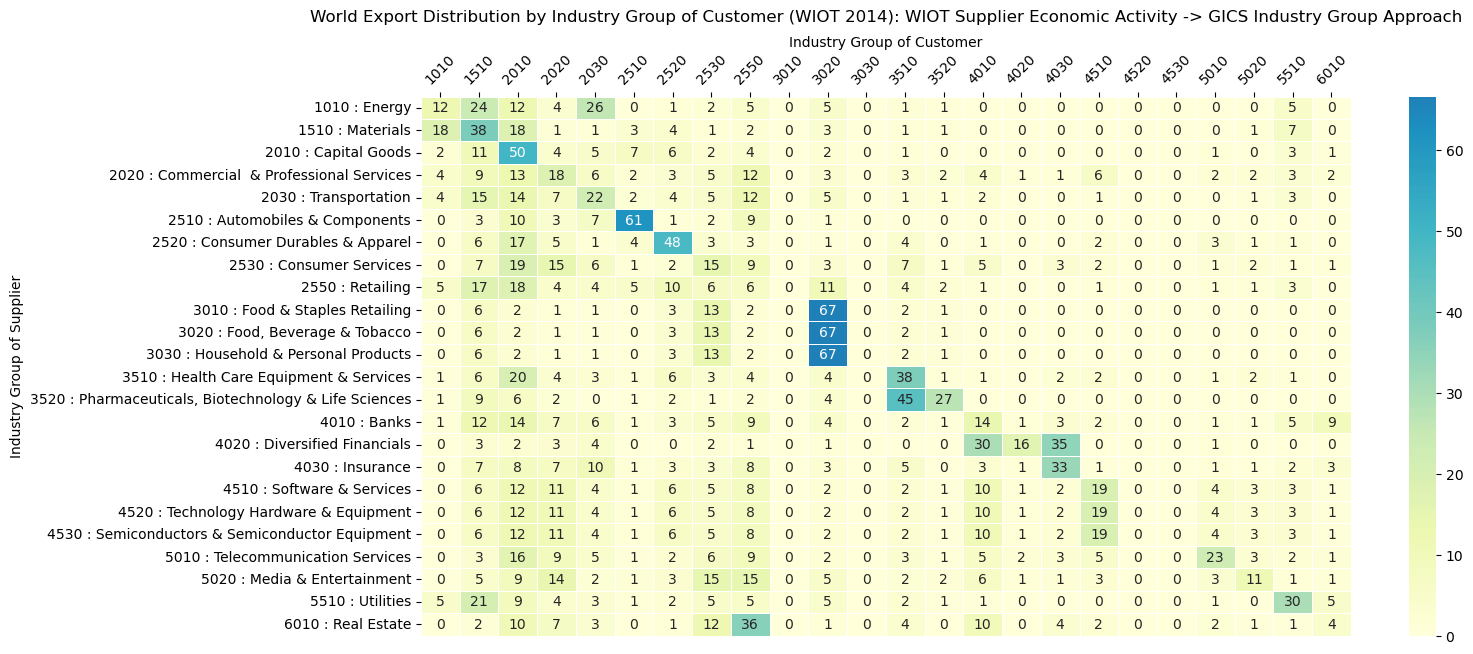

Old Version of Export Distribution Matrix: Supplier & Customer NACE Activities straightly mapped to GICS Industry Groups with GICS Groups shares consolidation by Columns & Rows
Some features:
1. Some rows (3020 -> 3010, 3020 -> 3030, 4510 -> 4520, 4510 -> 4530) are duplicated
2. Groups contain products that surely have different distribution


In [5]:
### OLD VERSION MATRIX

### Loading old version shares:
df_old_version = pd.read_csv(str_path_total_shares, index_col = 0)
df_old_version.index.names = ['Group_Code']
df_old_version.index = df_old_version.index.astype('str')
### Adding Industry Group Names:
df_gics_groups = pd.read_excel(str_path_matrix_map, str_sheet_gics, skiprows = 4, dtype = 'str', usecols = [2, 3]).dropna()
df_gics_groups.columns = ['Group_Code', 'Group_Name']
df_gics_groups['Industry_Group'] = df_gics_groups['Group_Code'].str.cat([' : '] * len(df_gics_groups)).str.cat(df_gics_groups['Group_Name'])
ser_gics_groups = df_gics_groups.set_index('Group_Code')['Industry_Group']
df_old_version = df_old_version.join(ser_gics_groups).set_index('Industry_Group')
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_old_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, center = 50, 
                         annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Industry Group of Supplier')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014): WIOT Supplier Economic Activity -> GICS Industry Group Approach', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('Old Version of Export Distribution Matrix: Supplier & Customer NACE Activities straightly mapped to GICS Industry Groups with GICS Groups shares ' + 
      'consolidation by Columns & Rows')
print('Some features:')
print('1. Some rows (3020 -> 3010, 3020 -> 3030, 4510 -> 4520, 4510 -> 4530) are duplicated')
print('2. Groups contain products that surely have different distribution')

In [6]:
### DETAILED DISTRIBUTION (WORLD TO WORLD)

gc.collect()
### Loading World to World Detailed Distribution:
dt_control = pd.to_datetime('2020-12-31')
ser_ww_ww_detailed = pd.read_hdf(str_path_unc_ind_weights_full_hdf, where = "Date in [dt_control]").droplevel('Date')['WW', 'WW']
### Aggregating to Industry Groups of Customer:
df_ww_ww_group = ser_ww_ww_detailed.to_frame().reset_index('GICS_Industry_Code')
df_ww_ww_group['GICS_Group_Code'] = df_ww_ww_group['GICS_Industry_Code'].str[: 4]
ser_ww_ww_group = df_ww_ww_group.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                .groupby(['Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
### Adding Commodity Descriptions:
ser_hs_info = pd.read_excel(str_path_matrix_map, str_sheet_hs, dtype = 'str').dropna().set_index('Commodity_ID')['AG2']
ser_hs_info = ser_hs_info.str.partition(';')[0]
ser_hs_info = ser_hs_info.str.partition(' - ')[0] + '(' + ser_hs_info.str.partition(' - ')[2] + ')'
ser_hs_info.name = 'Commodity_Description'
ser_ebops_info = pd.read_excel(str_path_matrix_map, str_sheet_ebops, dtype = 'str').dropna().set_index('Commodity_ID')['Service Description']
ser_ebops_info = ser_ebops_info.str.partition(' ')[0] + '(' + ser_ebops_info.str.partition(' ')[2] + ')'
ser_ebops_info.name = 'Commodity_Description'
ser_comm_info = pd.concat([ser_hs_info, ser_ebops_info], axis = 0)
ser_ww_ww_group = ser_ww_ww_group.to_frame().join(ser_comm_info).set_index('Commodity_Description', append = True).squeeze()
### R Map:
df_r_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_r, dtype = str)[['WIOT Exporter Code', 'WIOT Description', 'HS Goods Code', 'EBOPS Service Code']]
df_r_map[['WIOT Exporter Code', 'WIOT Description']] = df_r_map[['WIOT Exporter Code', 'WIOT Description']].ffill()
df_r_map['Commodity_ID'] = df_r_map['HS Goods Code'].combine_first(df_r_map['EBOPS Service Code'])
df_r_map['WIOT Description'] = df_r_map['WIOT Description'].str.partition(';')[0].str.partition(',')[0]
df_r_map['WIOT Description'] = df_r_map['WIOT Exporter Code'] + '(' + df_r_map['WIOT Description'] + ')'
df_r_map = df_r_map.dropna(subset = ['Commodity_ID']).set_index('Commodity_ID')[['WIOT Exporter Code', 'WIOT Description']]
### Adding NACE Description:
ser_ww_ww_group = ser_ww_ww_group.reset_index(['Commodity_Description', 'Commodity_Group_Code', 'GICS_Group_Code']).join(df_r_map)\
                                 .set_index(['Commodity_Description', 'WIOT Description', 'Commodity_Group_Code', 'GICS_Group_Code'], append = True)['Share']

C:\Users\ighar\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [7]:
### COMTRADE DATA LOADING

gc.collect()
ser_comtrade_bil = pd.read_hdf(str_path_export_bilateral, where = "Date in [dt_control]").droplevel(['Date', 'Type'])
ser_comtrade_bil.index.names = ['Exporter', 'Importer', 'Commodity_ID']
ser_comtrade_ww = (ser_comtrade_bil.groupby(['Commodity_ID']).sum() / 1000).astype(int)
ser_comtrade_xx_to_ww = (ser_comtrade_bil.groupby(['Exporter', 'Commodity_ID']).sum() / 1000).astype(int)
ser_comtrade_xx_to_ww.index.names = ['Exporter', 'Commodity_ID']

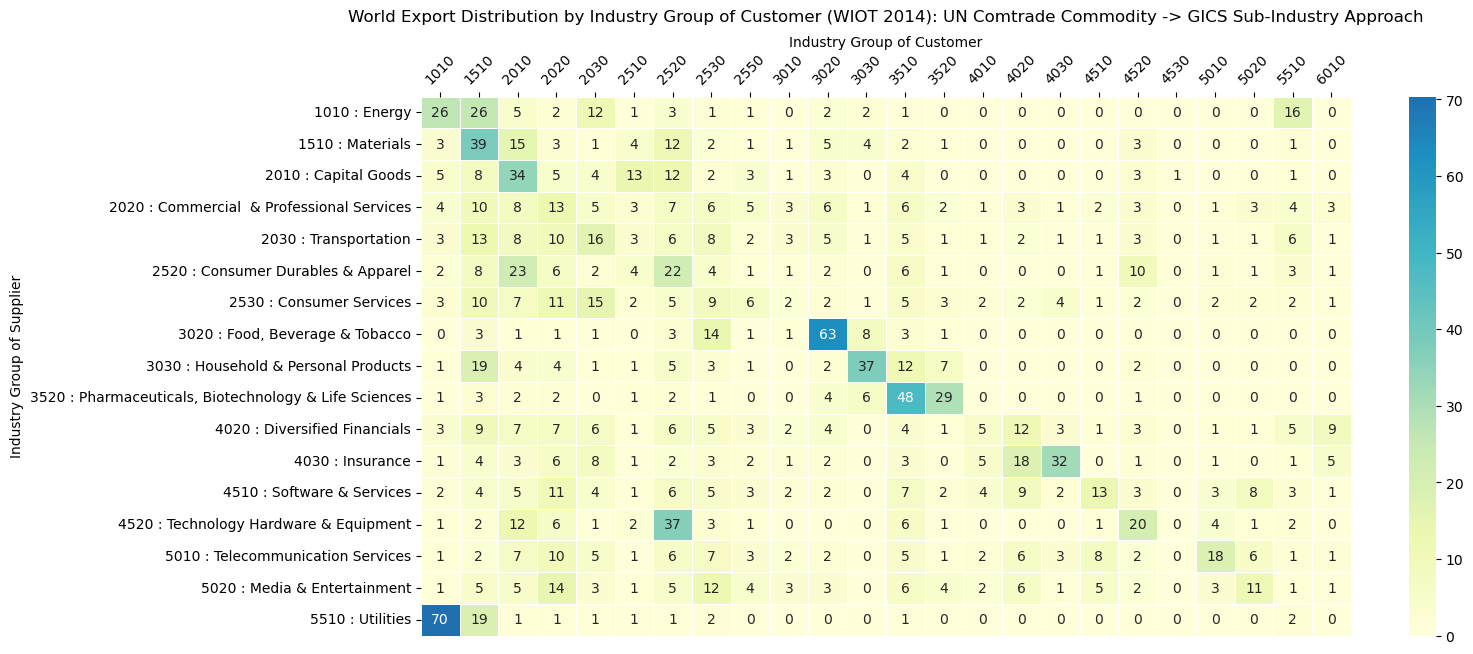

In [8]:
### NEW VERSION MATRIX

ser_to_compare = ser_ww_ww_group.to_frame().join(ser_comtrade_ww).groupby(['Commodity_Group_Code', 'GICS_Group_Code'], observed = True)\
                               .apply(lambda df_group: (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum())
df_to_compare = ser_to_compare.groupby('Commodity_Group_Code', observed = True).transform(lambda ser_i: ser_i / ser_i.sum()).unstack('GICS_Group_Code') 
### Adding Industry Group Names:
df_gics_groups = pd.read_excel(str_path_matrix_map, str_sheet_gics, skiprows = 4, dtype = 'str', usecols = [2, 3]).dropna()
df_gics_groups.columns = ['Group_Code', 'Group_Name']
df_gics_groups['Industry_Group'] = df_gics_groups['Group_Code'].str.cat([' : '] * len(df_gics_groups)).str.cat(df_gics_groups['Group_Name'])
df_gics_groups['Industry_Group'] = df_gics_groups['Group_Code'].str.cat([' : '] * len(df_gics_groups)).str.cat(df_gics_groups['Group_Name'])
df_to_compare = df_to_compare.reset_index()
df_to_compare['Commodity_Group_Code'] = df_to_compare['Commodity_Group_Code'].replace(df_gics_groups.set_index('Group_Code')['Industry_Group'])
df_to_compare = df_to_compare.set_index('Commodity_Group_Code')
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_compare.fillna(0.0) * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Industry Group of Supplier')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014): UN Comtrade Commodity -> GICS Sub-Industry Approach', pad = 10)
plt.xticks(rotation = 45)
plt.show() 

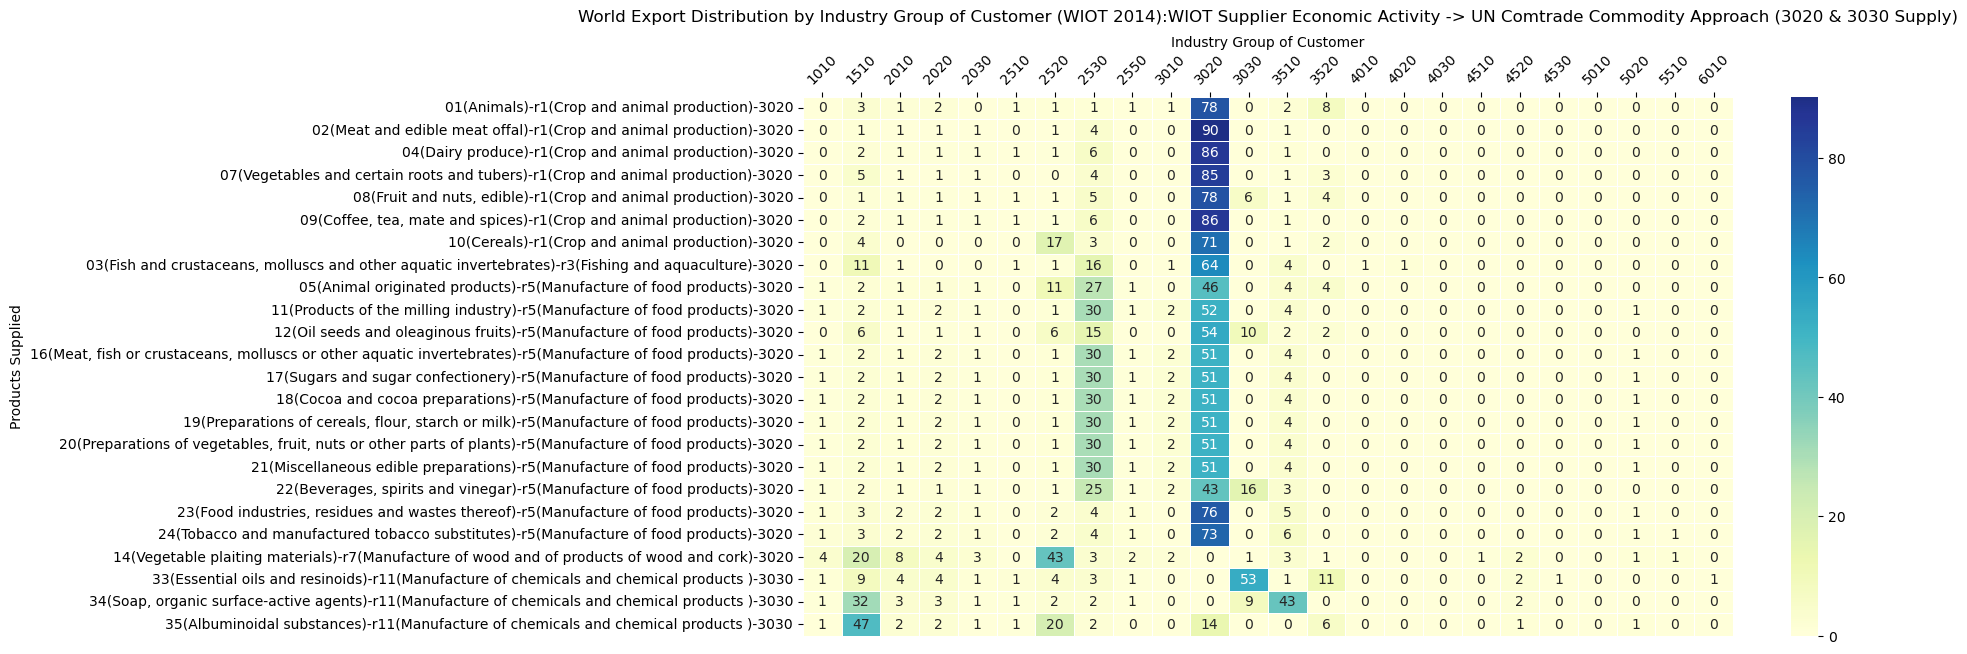

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)
3030 Group now have a standalone representation.


In [9]:
### NEW VERSION MATRIX: FOOD, BEVERAGE, TOBACCO

df_new_version = ser_ww_ww_group.loc[:, :, :, ['3020', '3030']].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)

### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (3020 & 3030 Supply)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')
print('3030 Group now have a standalone representation.')

In [10]:
### OLD WEAY DATA PREPARATION TO COMPARE WITH NEW WAY DATA BY INDUSTRY GROUP:

### Loading old version shares:
df_old_way_total = pd.read_csv(str_path_total_shares, index_col = 0)
df_old_way_total.index.names = ['Commodity_Group_Code']
df_old_way_total.index = df_old_way_total.index.astype('str')
df_old_way_total = pd.concat({'Old Way': pd.concat({'Total': df_old_way_total}, names = ['WIOT Description'])}, names = ['Commodity_Description'])
### Preparation of new version shares:
df_new_way_total = ser_ww_ww_group.to_frame().join(ser_comtrade_ww).groupby(['Commodity_Group_Code', 'GICS_Group_Code'], observed = True)\
                                  .apply(lambda df_group: (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum())\
                                  .unstack('GICS_Group_Code').fillna(0.0)
df_new_way_total = pd.concat({'New Way': pd.concat({'Total': df_new_way_total}, names = ['WIOT Description'])}, names = ['Commodity_Description'])

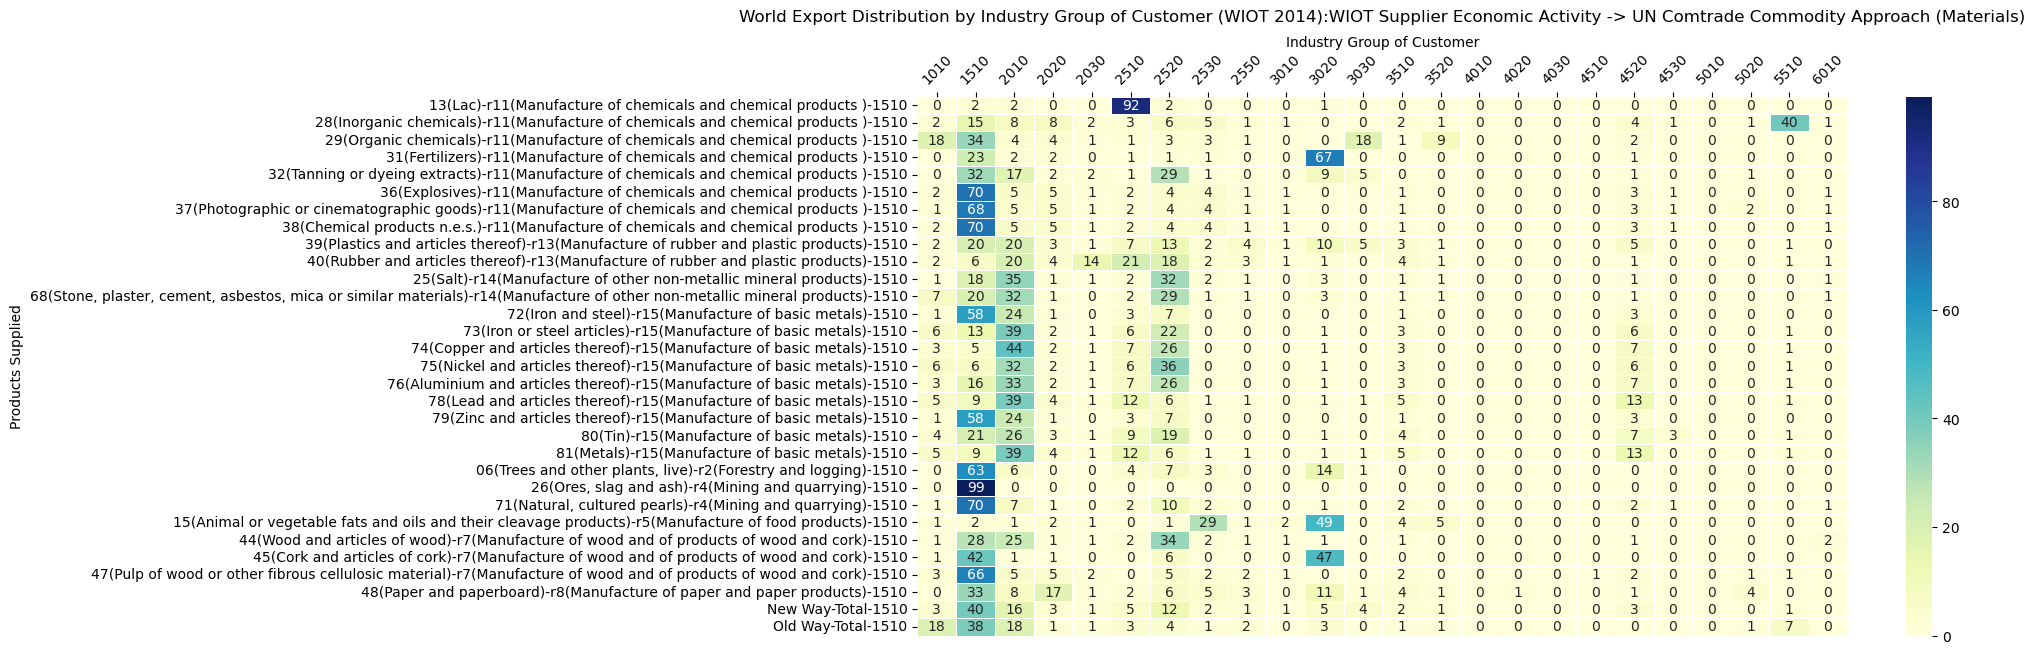

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)
9 different NACE Activities represents the single GICS Group.


In [11]:
### NEW VERSION MATRIX: MATERIALS

str_gics_group = '1510'
df_new_version = ser_ww_ww_group.loc[:, :, :, [str_gics_group]].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)
df_new_version = pd.concat([df_new_version, df_new_way_total.loc[(All, All, [str_gics_group]), :], df_old_way_total.loc[(All, All, [str_gics_group]), :]], axis = 0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Materials)', pad = 10)
plt.xticks(rotation = 45)
#wrap_labels(ax_heatmap, 50)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')
print('9 different NACE Activities represents the single GICS Group.')

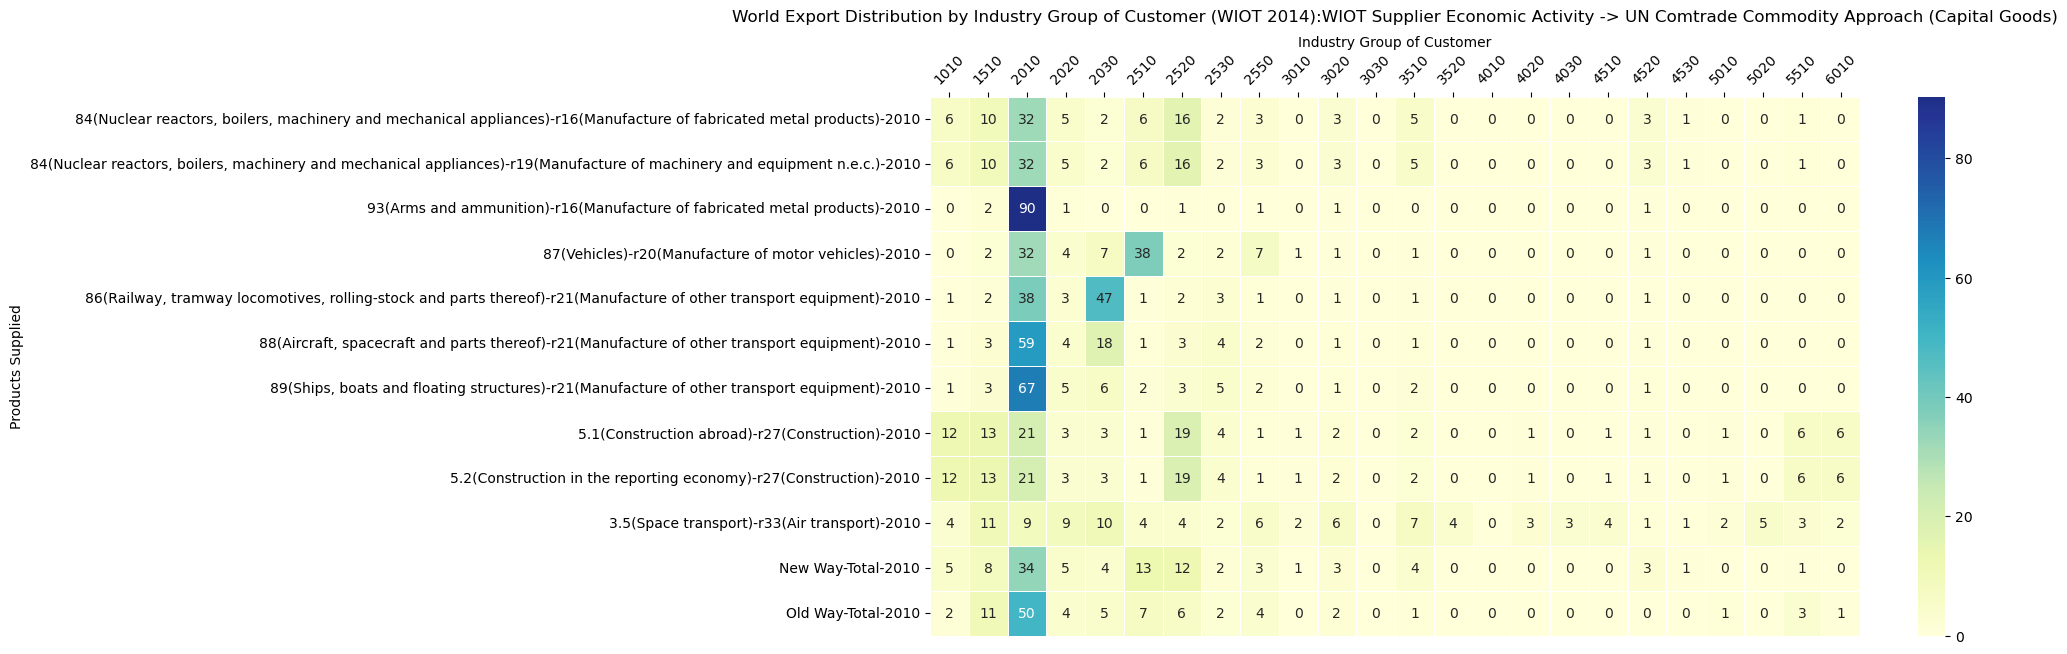

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)


In [12]:
### NEW VERSION MATRIX: CAPITAL GOODS

str_gics_group = '2010'
df_new_version = ser_ww_ww_group.loc[:, :, :, [str_gics_group]].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)
df_new_version = pd.concat([df_new_version, df_new_way_total.loc[(All, All, [str_gics_group]), :], df_old_way_total.loc[(All, All, [str_gics_group]), :]], axis = 0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Capital Goods)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')

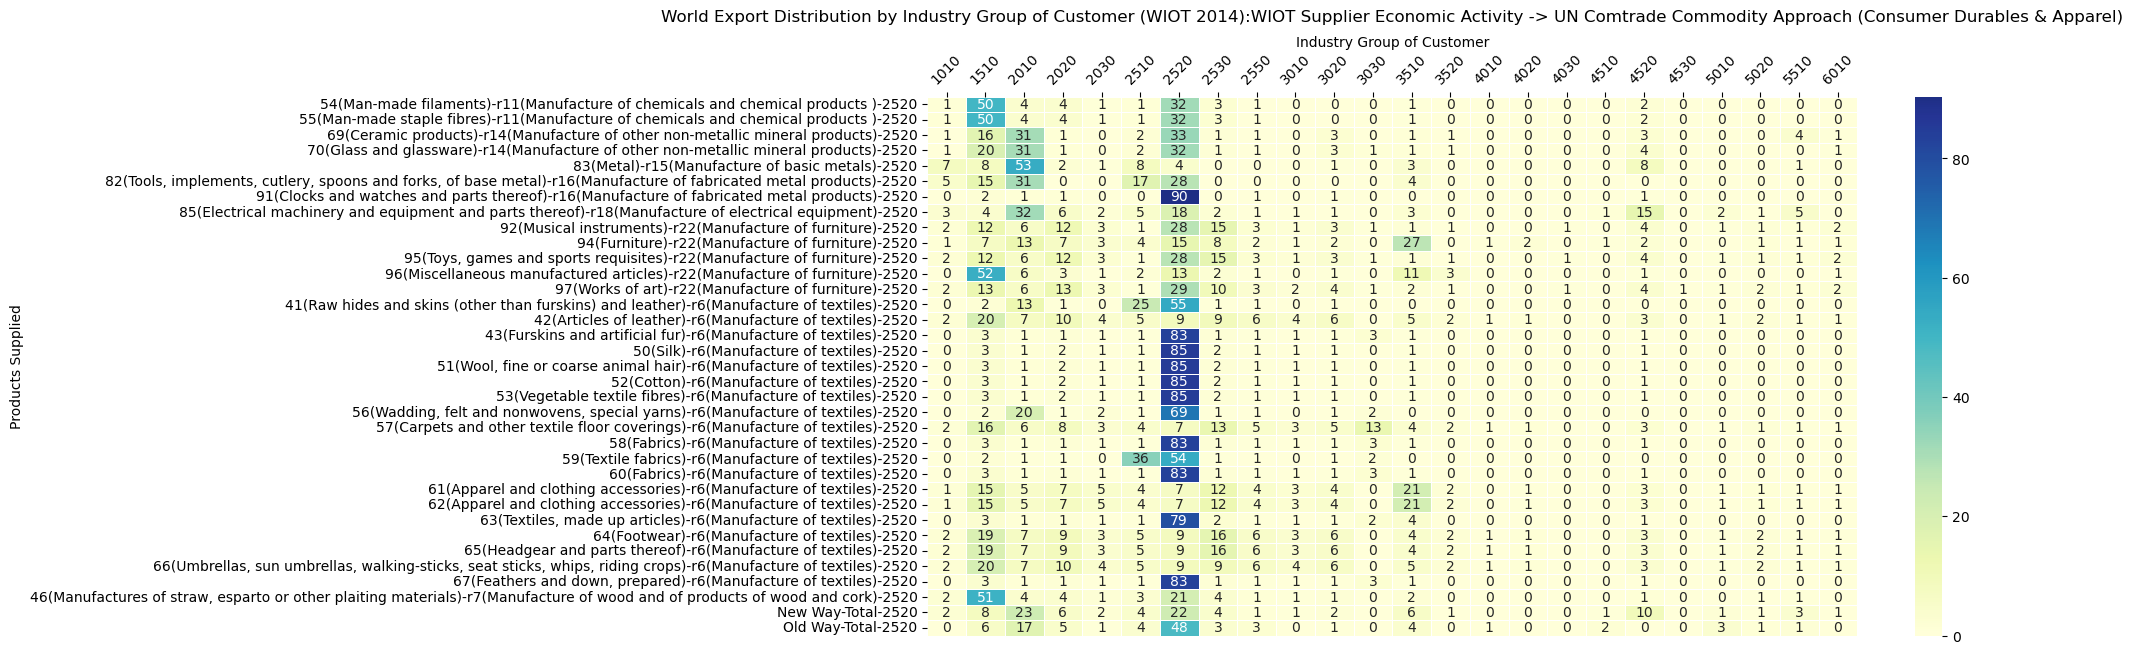

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)


In [13]:
### NEW VERSION MATRIX: CONSUMER DURABLES & APPAREL

str_gics_group = '2520'
df_new_version = ser_ww_ww_group.loc[:, :, :, [str_gics_group]].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)
df_new_version = pd.concat([df_new_version, df_new_way_total.loc[(All, All, [str_gics_group]), :], df_old_way_total.loc[(All, All, [str_gics_group]), :]], axis = 0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Consumer Durables & Apparel)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')

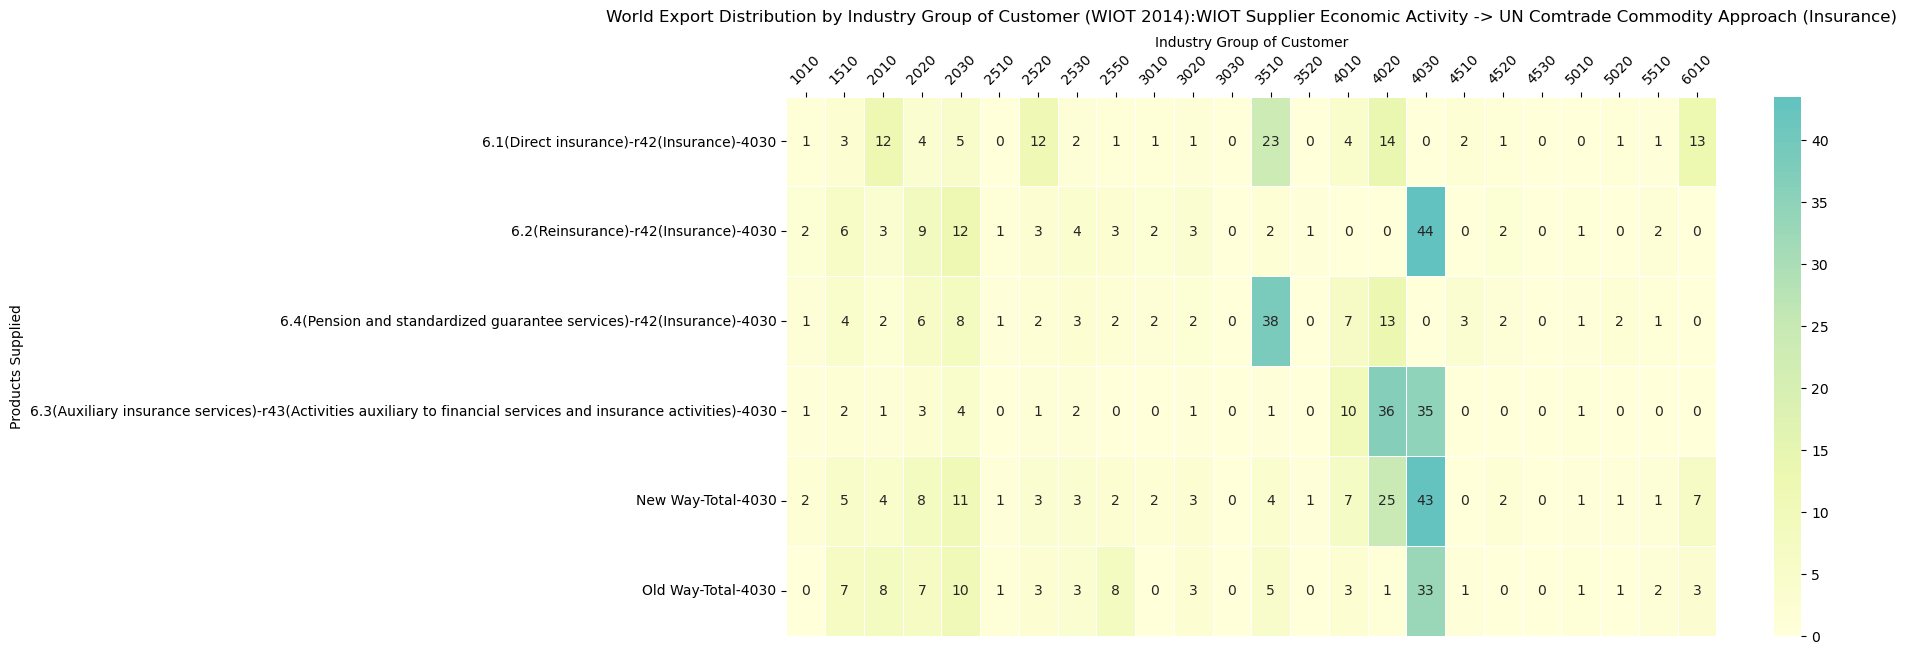

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)


In [14]:
### NEW VERSION MATRIX: CONSUMER DURABLES & APPAREL

str_gics_group = '4030'
df_new_version = ser_ww_ww_group.loc[:, :, :, [str_gics_group]].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)
df_new_version = pd.concat([df_new_version, df_new_way_total.loc[(All, All, [str_gics_group]), :], df_old_way_total.loc[(All, All, [str_gics_group]), :]], axis = 0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (Insurance)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')

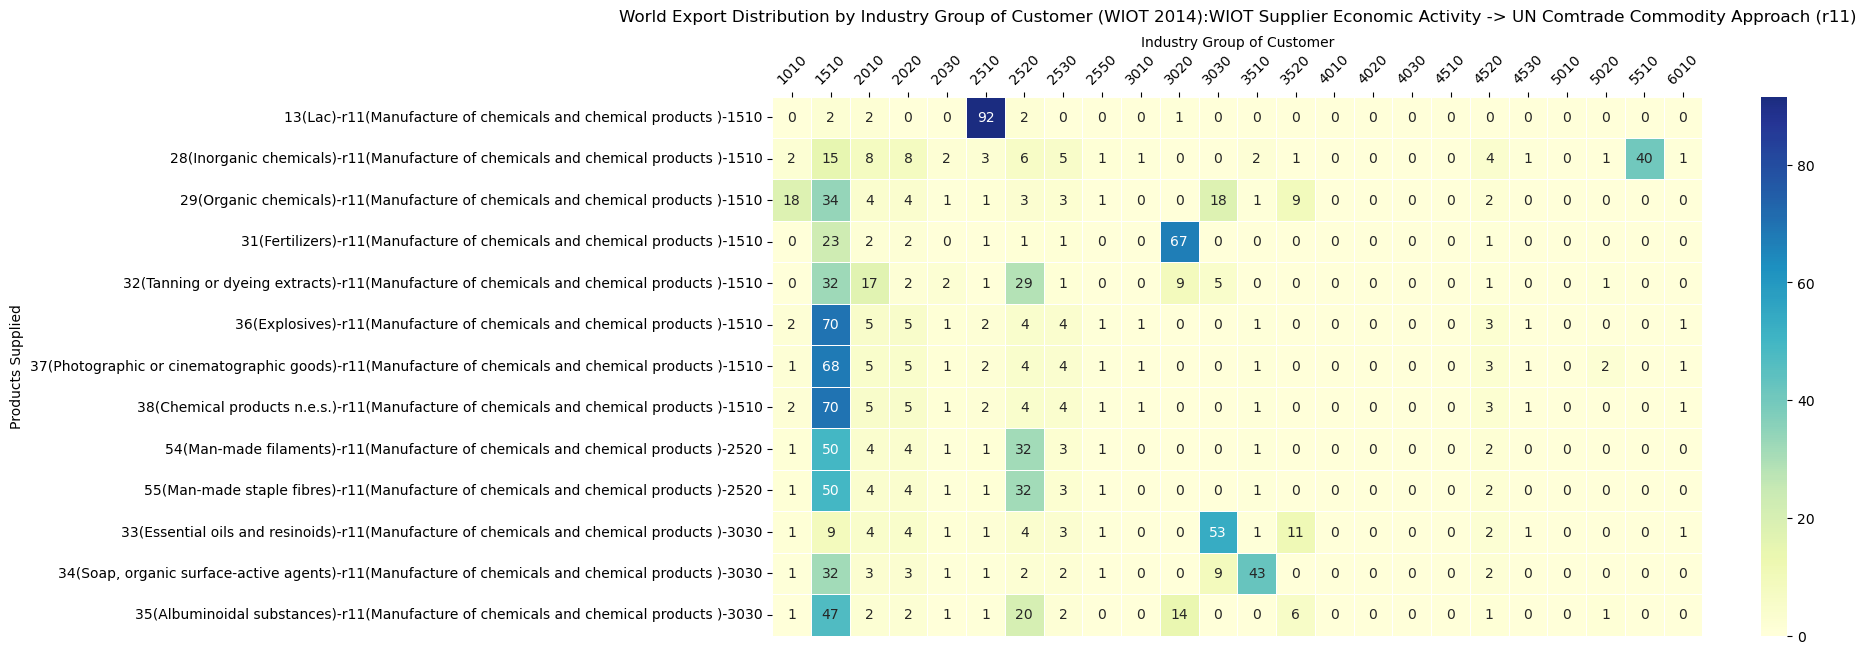

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)


In [15]:
### NEW VERSION MATRIX: R11

str_nace_activity = 'r11(Manufacture of chemicals and chemical products )'
df_new_version = ser_ww_ww_group.loc[:, :, [str_nace_activity], :].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (r11)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')

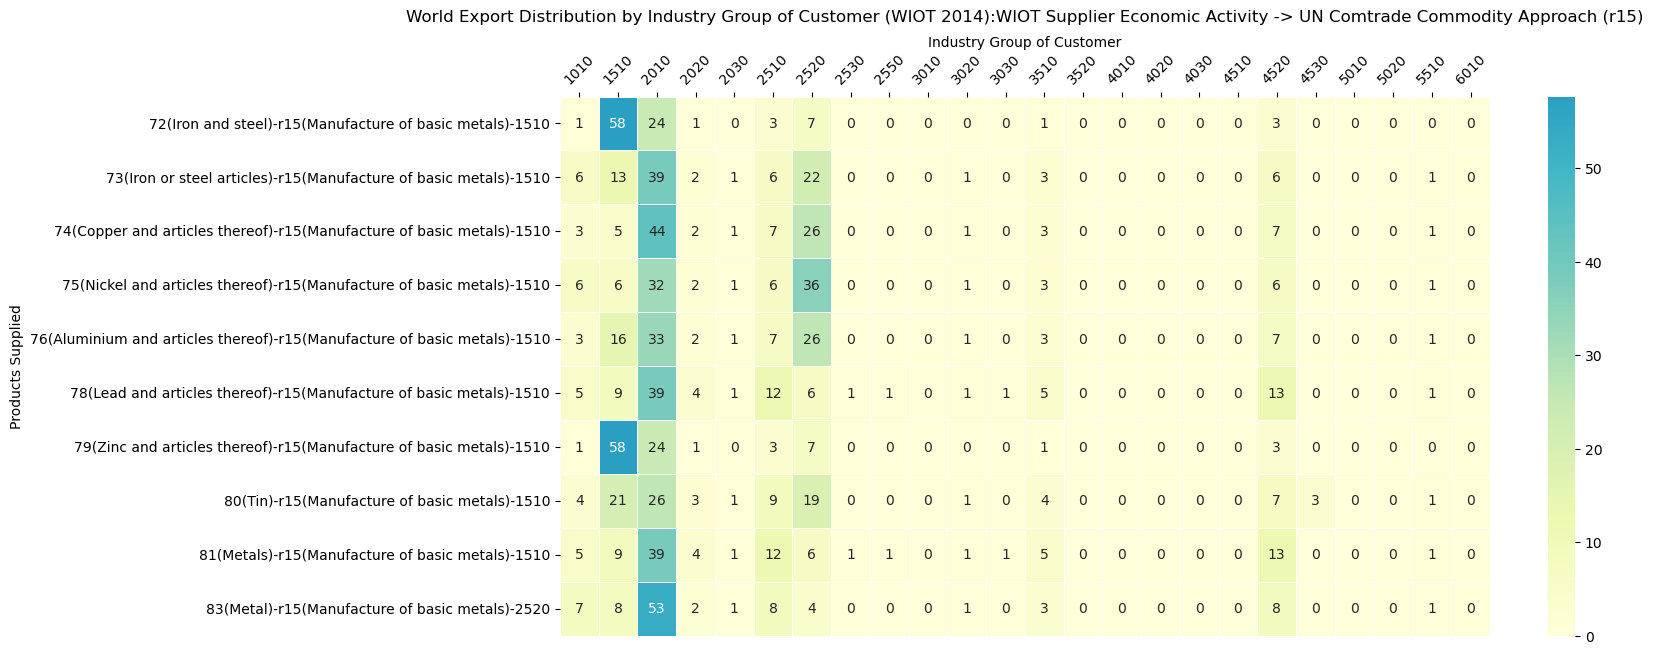

New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |Customer NACE Activities mapped to GICS Sub-Industries (1 to n)


In [16]:
### NEW VERSION MATRIX: R15

str_nace_activity = 'r15(Manufacture of basic metals)'
df_new_version = ser_ww_ww_group.loc[:, :, [str_nace_activity], :].droplevel(0).sort_index(level = [2, 1, 0], key = lambda x: x.str[: 4])\
                                .unstack('GICS_Group_Code').fillna(0.0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_new_version * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('World Export Distribution by Industry Group of Customer (WIOT 2014):' +
                     'WIOT Supplier Economic Activity -> UN Comtrade Commodity Approach (r15)', pad = 10)
plt.xticks(rotation = 45)
plt.show() 
print('New Version of Export Distribution Matrix: Supplier NACE Activities mapped to UN Comtrade Classified Goods & Services (1 to n) |' + 
      'Customer NACE Activities mapped to GICS Sub-Industries (1 to n)')

In [17]:
### DETAILED DISTRIBUTION (COUNTRY TO WORLD)

gc.collect()
### Loading World to World Detailed Distribution:
dt_control = pd.to_datetime('2020-12-31')
ser_xx_ww_detailed = pd.read_hdf(str_path_unc_ind_weights_agg_hdf, where = "Date in [dt_control]").droplevel('Date')[:, 'WW']
### Aggregating to Industry Groups of Customer:
df_xx_ww_group = ser_xx_ww_detailed.to_frame().reset_index('GICS_Industry_Code')
df_xx_ww_group['GICS_Group_Code'] = df_xx_ww_group['GICS_Industry_Code'].str[: 4]
df_xx_ww_group = df_xx_ww_group.drop(['YY', 'WW'], axis = 0)
ser_xx_ww_group = df_xx_ww_group.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                .groupby(['Exporter', 'Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
### Adding Commodity Descriptions:
ser_hs_info = pd.read_excel(str_path_matrix_map, str_sheet_hs, dtype = 'str').dropna().set_index('Commodity_ID')['AG2']
ser_hs_info = ser_hs_info.str.partition(';')[0]
ser_hs_info = ser_hs_info.str.partition(' - ')[0] + '(' + ser_hs_info.str.partition(' - ')[2] + ')'
ser_hs_info.name = 'Commodity_Description'
ser_ebops_info = pd.read_excel(str_path_matrix_map, str_sheet_ebops, dtype = 'str').dropna().set_index('Commodity_ID')['Service Description']
ser_ebops_info = ser_ebops_info.str.partition(' ')[0] + '(' + ser_ebops_info.str.partition(' ')[2] + ')'
ser_ebops_info.name = 'Commodity_Description'
ser_comm_info = pd.concat([ser_hs_info, ser_ebops_info], axis = 0)
ser_xx_ww_group = ser_xx_ww_group.to_frame().join(ser_comm_info).set_index('Commodity_Description', append = True).squeeze()
### R Map:
df_r_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_r, dtype = str)[['WIOT Exporter Code', 'WIOT Description', 'HS Goods Code', 'EBOPS Service Code']]
df_r_map[['WIOT Exporter Code', 'WIOT Description']] = df_r_map[['WIOT Exporter Code', 'WIOT Description']].ffill()
df_r_map['Commodity_ID'] = df_r_map['HS Goods Code'].combine_first(df_r_map['EBOPS Service Code'])
df_r_map['WIOT Description'] = df_r_map['WIOT Description'].str.partition(';')[0].str.partition(',')[0]
df_r_map['WIOT Description'] = df_r_map['WIOT Exporter Code'] + '(' + df_r_map['WIOT Description'] + ')'
df_r_map = df_r_map.dropna(subset = ['Commodity_ID']).set_index('Commodity_ID')[['WIOT Exporter Code', 'WIOT Description']]
### Adding NACE Description:
ser_xx_ww_group = ser_xx_ww_group.reset_index(['Exporter', 'Commodity_Description', 'Commodity_Group_Code', 'GICS_Group_Code']).join(df_r_map)\
                            .set_index(['Exporter', 'Commodity_Description', 'WIOT Description', 'Commodity_Group_Code', 'GICS_Group_Code'], append = True)['Share']\
                            .swaplevel(0, 1).sort_index()
### List of countries to research:
list_nace_countries = ser_xx_ww_group.index.levels[0].to_list()
list_nace_countries.remove('TW')
list_nace_countries.remove('YY')
list_nace_countries.remove('WW')

C:\Users\ighar\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


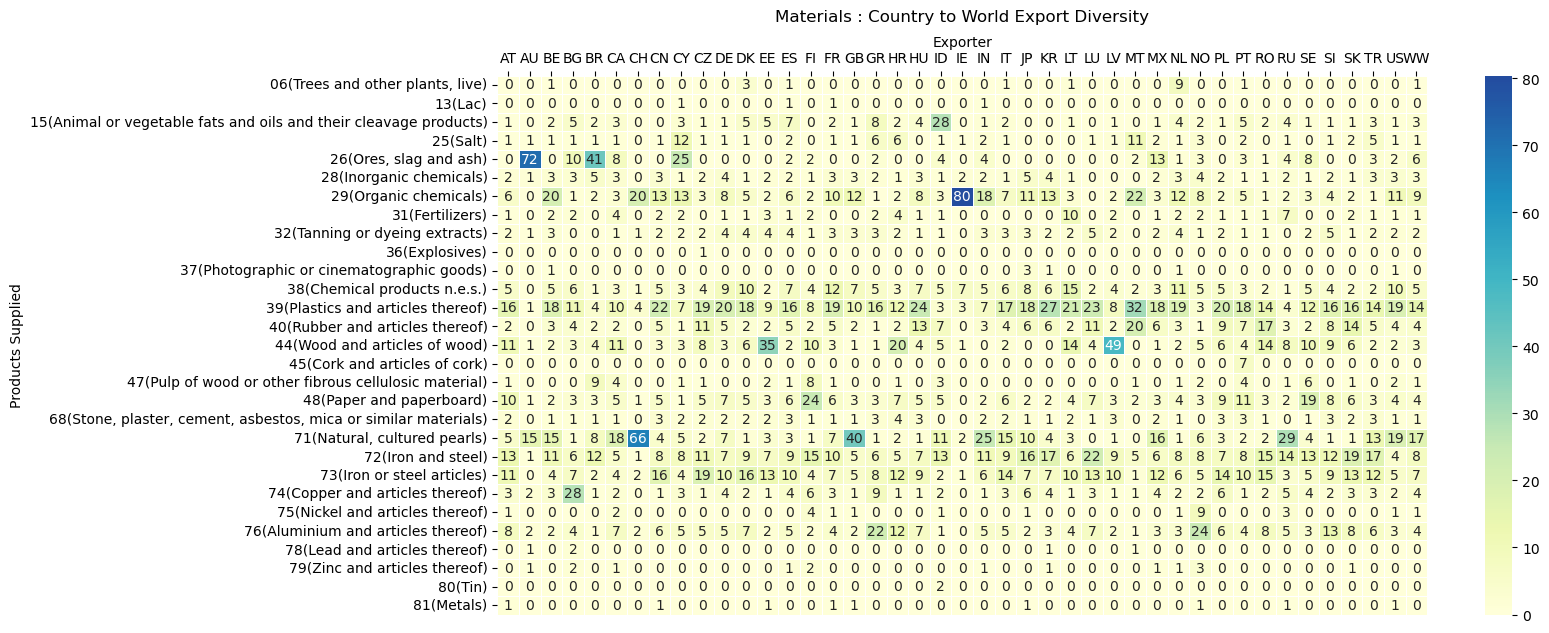

In [18]:
### TEST: COUNTRY-TO-WORLD MATERIALS: EXPORT DIVERSITY

str_group = '1510'
### Country to world selection:
ser_xx_ww_example = ser_xx_ww_group.loc[:, :, :, :, str_group, :]
ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww.loc[ser_xx_ww_example.index.droplevel([2, 3, 4]).drop_duplicates()]
ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww_example.groupby(['Exporter']).transform(lambda ser_i: ser_i / ser_i.sum())
#ser_comtrade_xx_to_ww_example.groupby(['Exporter']).apply(lambda ser_i: print(ser_i.nlargest(5)))
### World to world adding:
ser_comtrade_ww_example = ser_comtrade_ww[ser_xx_ww_example.index.droplevel([0, 2, 3, 4]).drop_duplicates()]
ser_comtrade_ww_example = ser_comtrade_ww_example / ser_comtrade_ww_example.sum()
ser_comtrade_xx_to_ww_example = pd.concat([ser_comtrade_xx_to_ww_example, pd.concat({'WW': ser_comtrade_ww_example}, names = ['Exporter'])], axis = 0).sort_index()
### Filtering countries to illustrate diversity:
#list_countries = ['AU', 'BR', 'CA', 'CH', 'CN', 'DE', 'GB', 'JP', 'RU', 'US', 'WW']
#ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww_example[list_countries]
ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww_example.to_frame().join(ser_comm_info)\
                                                             .set_index('Commodity_Description', append = True).squeeze().droplevel('Commodity_ID')

### Export of materials diversity plot:
df_xx_to_ww = ser_comtrade_xx_to_ww_example.unstack('Exporter').fillna(0.0)
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_xx_to_ww * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Exporter')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Materials' + ' : Country to World Export Diversity', pad = 10)
plt.show()

In [19]:
### DIVISION BY ZERO HANDLING

def weighted_ave_zero(df_group):
    if (df_group['Export'].sum() > 0.0):
        return (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum()

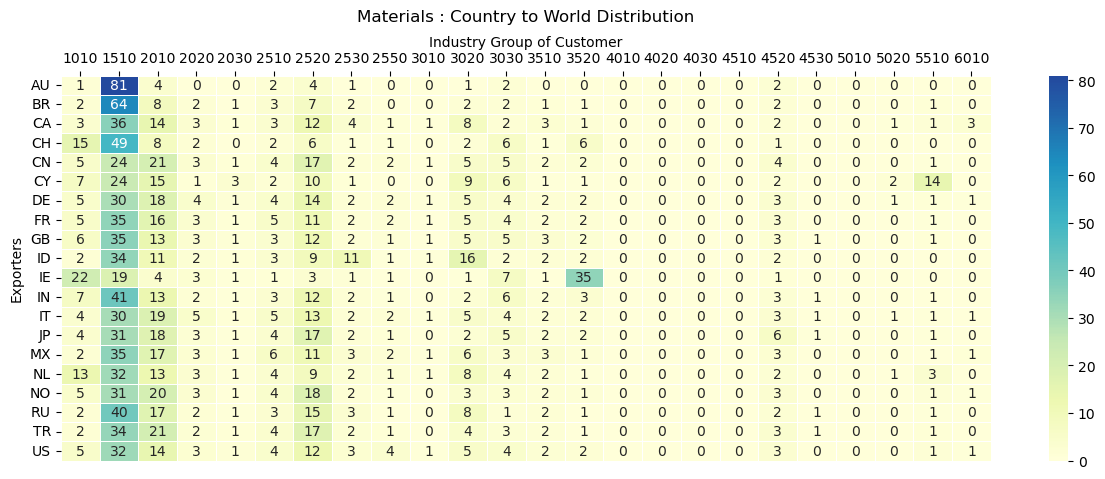

In [20]:
### TEST: COUNTRY-TO-WORLD MATERIALS: RESULT

gc.collect()
ser_xx_ww_result = ser_xx_ww_group.to_frame().join(ser_comtrade_xx_to_ww).groupby(['Exporter', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True)\
                                  .apply(weighted_ave_zero)
ser_xx_ww_result = ser_xx_ww_result.groupby(['Exporter', 'Commodity_Group_Code'], observed = True).transform(lambda ser_i: ser_i / ser_i.sum())
list_countries = ['AU', 'BR', 'CA', 'CH', 'CN', 'CY', 'DE', 'FR', 'GB', 'ID', 'IE', 'IN', 'IT', 'JP', 'MX', 'NL', 'NO', 'RU', 'TR', 'US']
df_xx_ww_result = ser_xx_ww_result.loc[list_countries, [str_group], :].droplevel('Commodity_Group_Code').unstack('GICS_Group_Code').fillna(0.0)

plt.figure(figsize = (15, 5))
ax_heatmap = sns.heatmap(df_xx_ww_result * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Exporters')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Materials' + ' : Country to World Distribution', pad = 10)
plt.show()

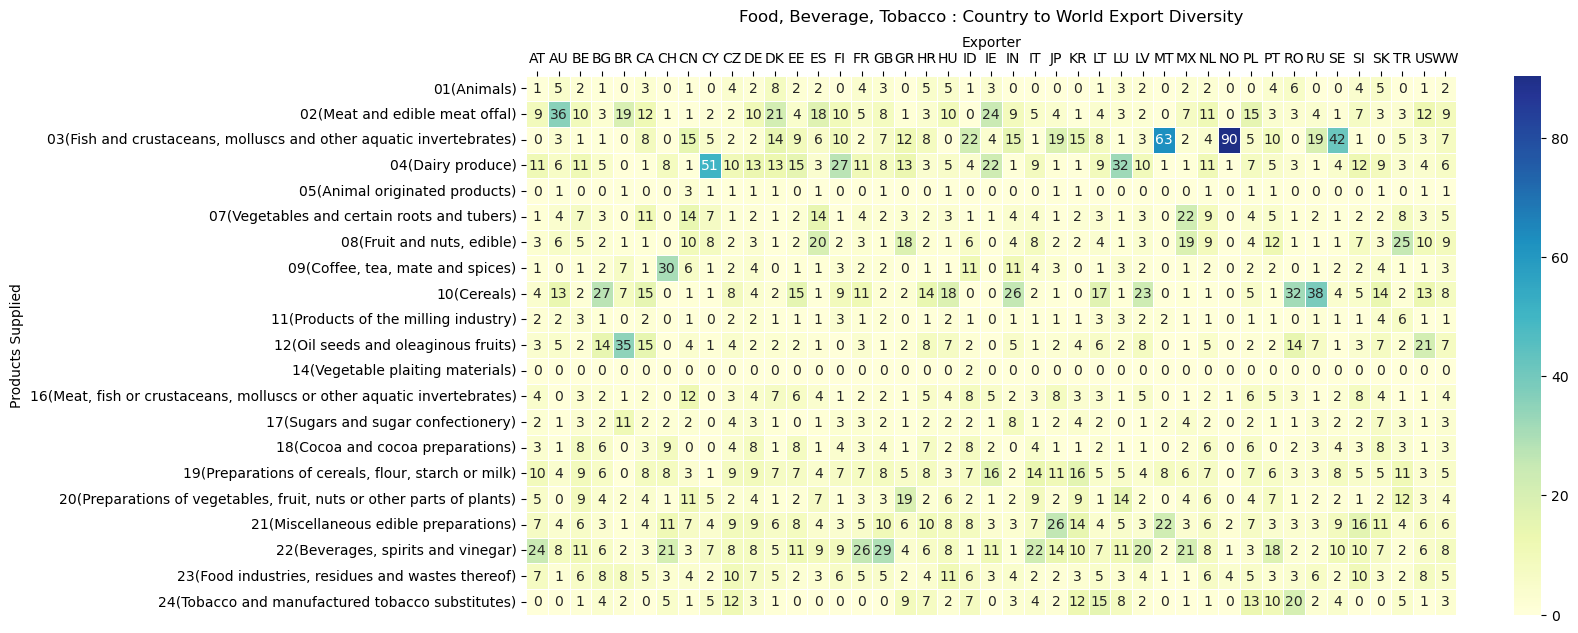

In [21]:
### TEST: COUNTRY-TO-WORLD FOOD / BEVERAGE / TOBACCO: EXPORT DIVERSITY

str_group = '3020'
### Country to world selection:
ser_xx_ww_example = ser_xx_ww_group.loc[:, :, :, :, str_group, :]
ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww.loc[ser_xx_ww_example.index.droplevel([2, 3, 4]).drop_duplicates()]
ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww_example.groupby(['Exporter']).transform(lambda ser_i: ser_i / ser_i.sum())
#ser_comtrade_xx_to_ww_example.groupby(['Exporter']).apply(lambda ser_i: print(ser_i.nlargest(5)))
### World to world adding:
ser_comtrade_ww_example = ser_comtrade_ww[ser_xx_ww_example.index.droplevel([0, 2, 3, 4]).drop_duplicates()]
ser_comtrade_ww_example = ser_comtrade_ww_example / ser_comtrade_ww_example.sum()
ser_comtrade_xx_to_ww_example = pd.concat([ser_comtrade_xx_to_ww_example, pd.concat({'WW': ser_comtrade_ww_example}, names = ['Exporter'])], axis = 0).sort_index()
### Filtering countries to illustrate diversity:
#list_countries = ['AU', 'BR', 'CA', 'CH', 'CN', 'DE', 'GB', 'JP', 'RU', 'US', 'WW']
#ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww_example[list_countries]
ser_comtrade_xx_to_ww_example = ser_comtrade_xx_to_ww_example.to_frame().join(ser_comm_info)\
                                                             .set_index('Commodity_Description', append = True).squeeze().droplevel('Commodity_ID')

### Export of materials diversity plot:
df_xx_to_ww = ser_comtrade_xx_to_ww_example.unstack('Exporter').fillna(0.0)
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_xx_to_ww * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Products Supplied')
ax_heatmap.set(xlabel = 'Exporter')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Food, Beverage, Tobacco' + ' : Country to World Export Diversity', pad = 10)
plt.show()

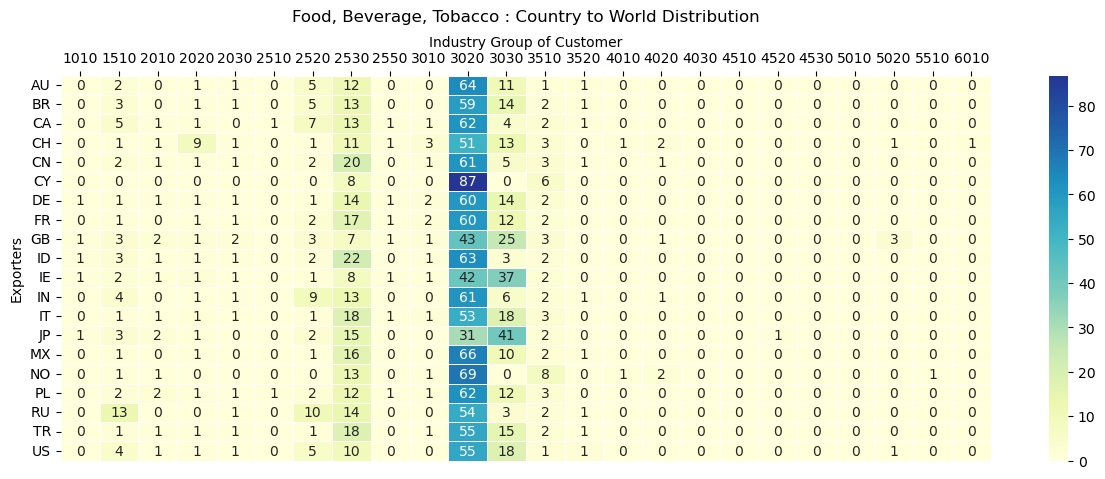

In [22]:
### TEST: COUNTRY-TO-WORLD FOOD / BEVERAGE / TOBACCO: RESULT

gc.collect()
ser_xx_ww_result = ser_xx_ww_group.to_frame().join(ser_comtrade_xx_to_ww).groupby(['Exporter', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True)\
                                  .apply(weighted_ave_zero)
ser_xx_ww_result = ser_xx_ww_result.groupby(['Exporter', 'Commodity_Group_Code'], observed = True).transform(lambda ser_i: ser_i / ser_i.sum())
list_countries = ['AU', 'BR', 'CA', 'CH', 'CN', 'CY', 'DE', 'FR', 'GB', 'ID', 'IE', 'IN', 'IT', 'JP', 'MX', 'NO', 'PL', 'RU', 'TR', 'US']
df_xx_ww_result = ser_xx_ww_result.loc[list_countries, [str_group], :].droplevel('Commodity_Group_Code').unstack('GICS_Group_Code').fillna(0.0)

plt.figure(figsize = (15, 5))
ax_heatmap = sns.heatmap(df_xx_ww_result * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 50, annot = True, fmt = '0.0f')
ax_heatmap.set(ylabel = 'Exporters')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Food, Beverage, Tobacco' + ' : Country to World Distribution', pad = 10)
plt.show()

In [23]:
### DETAILED DISTRIBUTION (COUNTRY TO COUNTRY)

gc.collect()
### Loading World to World Detailed Distribution:
dt_control = pd.to_datetime('2020-12-31')
ser_xx_ww_detailed = pd.read_hdf(str_path_unc_ind_weights_hdf, where = "Date in [dt_control]").droplevel('Date')
### Aggregating to Industry Groups of Customer:
df_xx_xx_group = ser_xx_ww_detailed.to_frame().reset_index('GICS_Industry_Code')
df_xx_xx_group['GICS_Group_Code'] = df_xx_xx_group['GICS_Industry_Code'].str[: 4]
df_xx_xx_group = df_xx_xx_group.drop(['YY', 'WW'], axis = 0)
ser_xx_xx_group = df_xx_xx_group.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                .groupby(['Exporter', 'Importer', 'Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
### Adding Commodity Descriptions:
ser_hs_info = pd.read_excel(str_path_matrix_map, str_sheet_hs, dtype = 'str').dropna().set_index('Commodity_ID')['AG2']
ser_hs_info = ser_hs_info.str.partition(';')[0]
ser_hs_info = ser_hs_info.str.partition(' - ')[0] + '(' + ser_hs_info.str.partition(' - ')[2] + ')'
ser_hs_info.name = 'Commodity_Description'
ser_ebops_info = pd.read_excel(str_path_matrix_map, str_sheet_ebops, dtype = 'str').dropna().set_index('Commodity_ID')['Service Description']
ser_ebops_info = ser_ebops_info.str.partition(' ')[0] + '(' + ser_ebops_info.str.partition(' ')[2] + ')'
ser_ebops_info.name = 'Commodity_Description'
ser_comm_info = pd.concat([ser_hs_info, ser_ebops_info], axis = 0)
ser_xx_xx_group = ser_xx_xx_group.to_frame().join(ser_comm_info).set_index('Commodity_Description', append = True).squeeze()
### R Map:
df_r_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_r, dtype = str)[['WIOT Exporter Code', 'WIOT Description', 'HS Goods Code', 'EBOPS Service Code']]
df_r_map[['WIOT Exporter Code', 'WIOT Description']] = df_r_map[['WIOT Exporter Code', 'WIOT Description']].ffill()
df_r_map['Commodity_ID'] = df_r_map['HS Goods Code'].combine_first(df_r_map['EBOPS Service Code'])
df_r_map['WIOT Description'] = df_r_map['WIOT Description'].str.partition(';')[0].str.partition(',')[0]
df_r_map['WIOT Description'] = df_r_map['WIOT Exporter Code'] + '(' + df_r_map['WIOT Description'] + ')'
df_r_map = df_r_map.dropna(subset = ['Commodity_ID']).set_index('Commodity_ID')[['WIOT Exporter Code', 'WIOT Description']]
### Adding NACE Description:
ser_xx_xx_group = ser_xx_xx_group.reset_index(['Exporter', 'Importer', 'Commodity_Description', 'Commodity_Group_Code', 'GICS_Group_Code']).join(df_r_map)\
                .set_index(['Exporter', 'Importer', 'Commodity_Description', 'WIOT Description', 'Commodity_Group_Code', 'GICS_Group_Code'], append = True)['Share']\
                .reorder_levels([1, 2, 0, 3, 4, 5, 6]).sort_index()
### List of countries to research:
list_nace_countries = ser_xx_ww_group.index.levels[0].to_list()
list_nace_countries.remove('TW')
list_nace_countries.remove('YY')
list_nace_countries.remove('WW')

C:\Users\ighar\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [34]:
### COUNTRY TO COUNTRY DISTRIBUTION PREPARATION

gc.collect()
ser_xx_xx_search = ser_xx_xx_group.droplevel([3, 4, 5])
ser_xx_xx_search = ser_xx_xx_search.groupby(['Exporter', 'Importer', 'Commodity_ID', 'GICS_Group_Code'], observed = True)\
                                   .apply(lambda ser_i: ser_i.mean(axis = 0))
ser_xx_xx_search = ser_xx_xx_search.groupby(['Exporter', 'Importer', 'Commodity_ID'], group_keys = False, observed = True).apply(lambda ser_i: ser_i / ser_i.sum())

In [40]:
### COUNTRY TO COUNTRY DISTRIBUTION : RESEARCH

str_exporter = 'US'
#list_importers = ['AU', 'BR', 'CA', 'CN', 'DE', 'FR', 'GB', 'IT', 'JP', 'KR', 'MX', 'RU', 'US']
list_importers = ['CA', 'CN', 'GB', 'JP', 'MX'] # Top Partners
list_commodities = ['27', '84', '85', '87', '7.1']
ser_xx_xx_test = ser_xx_xx_search.loc[str_exporter, list_importers, list_commodities]
df_xx_xx_test = ser_xx_xx_test.unstack('GICS_Group_Code').fillna(0.0)
df_xx_xx_test.groupby('Commodity_ID', observed = True)\
             .apply(lambda df_i: df_i.droplevel('Commodity_ID').transpose().corr().stack(['Exporter', 'Importer']).nsmallest())

Exporter  Importer  Exporter  Importer
US        CA        US        GB          0.377340
          GB        US        CA          0.377340
                              MX          0.379571
          MX        US        GB          0.379571
          JP        US        MX          0.578476
          GB        US        MX          0.112380
          MX        US        GB          0.112380
          CN        US        GB          0.157669
          GB        US        CN          0.157669
          CN        US        JP          0.312889
          JP        US        MX          0.856409
          MX        US        JP          0.856409
          CA        US        MX          0.869077
          MX        US        CA          0.869077
          CA        US        CN          0.872864
          GB        US        JP          0.821896
          JP        US        GB          0.821896
          GB        US        MX          0.845086
          MX        US        GB          0

In [41]:
### COUNTRY TO COUNTRY DISTRIBUTION : RESEARCH

ser_comtrade_test = ser_comtrade_bil.loc[str_exporter, list_importers, :].droplevel('Exporter')
ser_comtrade_test.groupby('Commodity_ID').apply(lambda ser_i: ser_i.sum() / ser_comtrade_test.sum()).nlargest(10)

Commodity_ID
7.1     0.151305
84      0.098137
85      0.083657
87      0.064145
27      0.063239
39      0.034987
90      0.033002
10.2    0.032403
71      0.026665
4.2     0.026184
Name: Export, dtype: float32

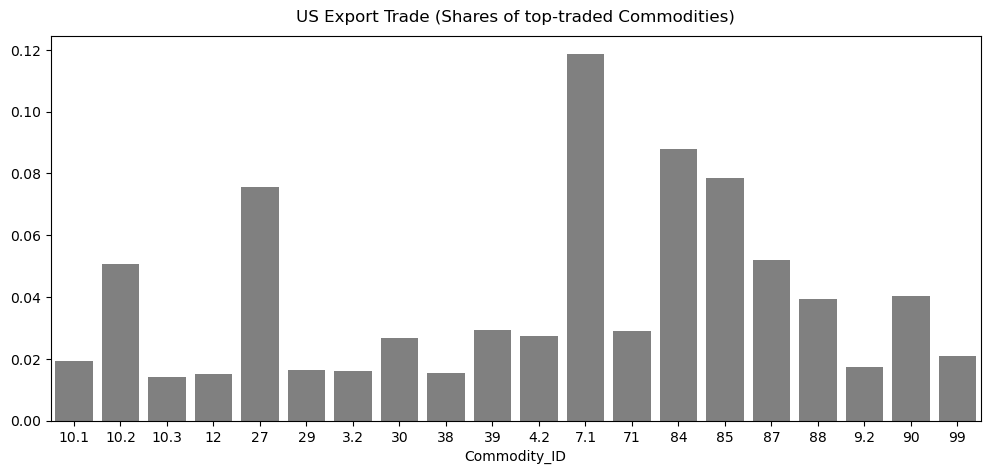

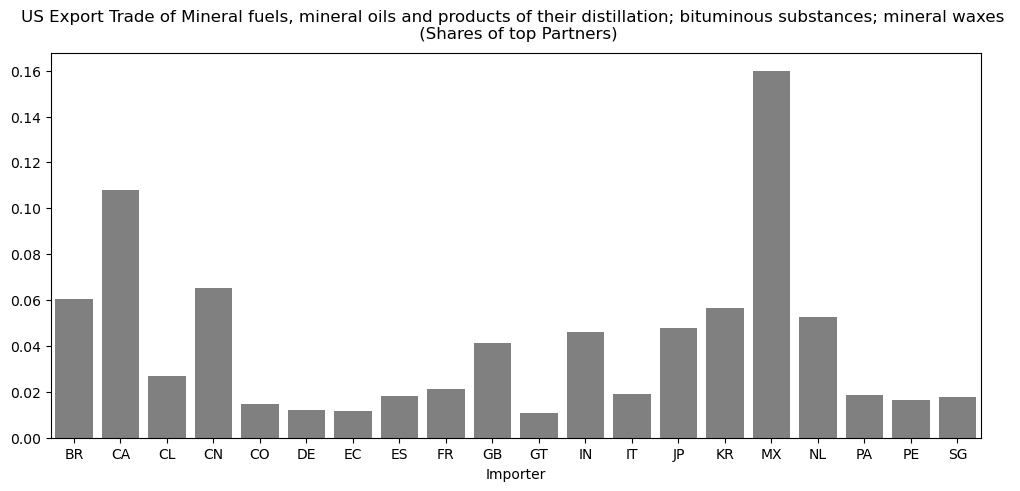

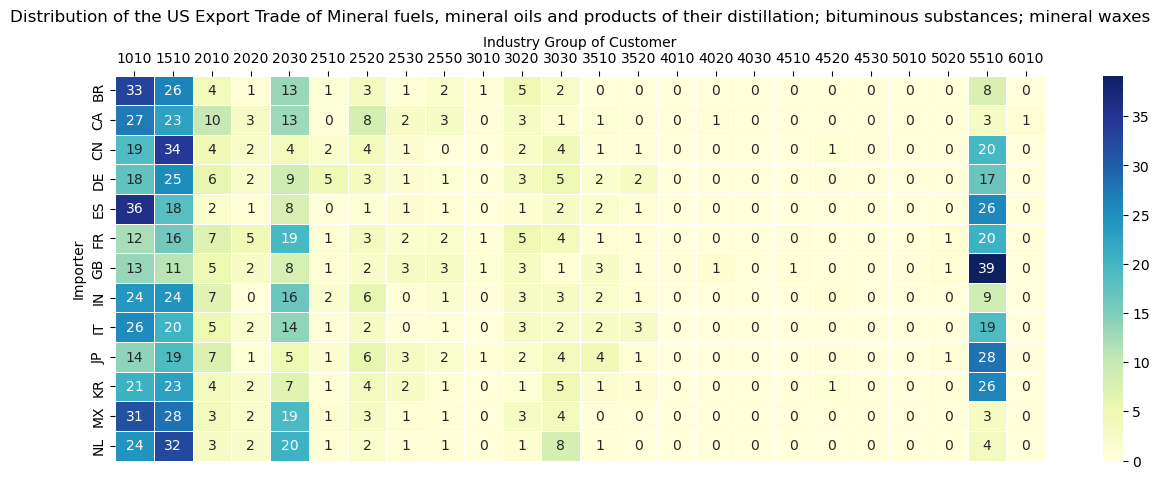

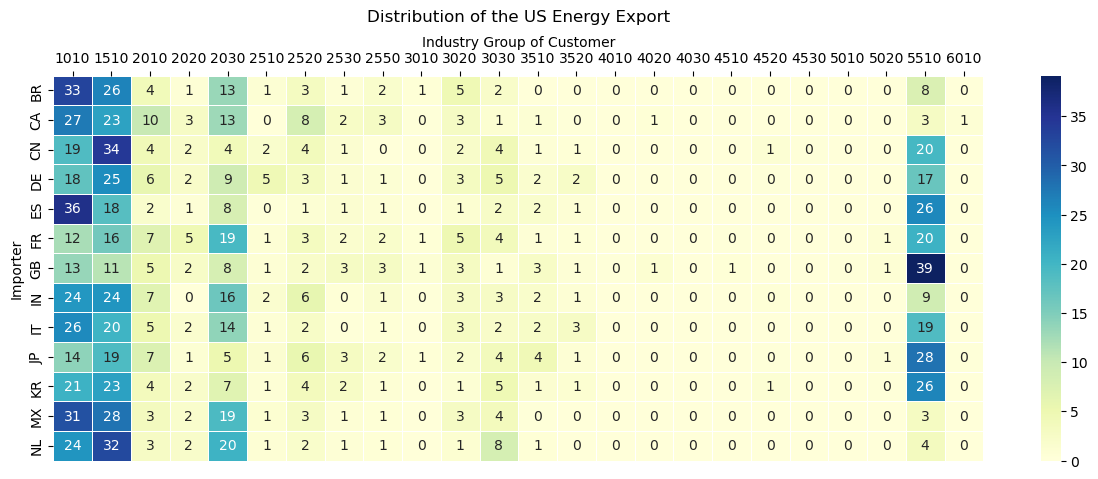

In [42]:
### COUNTRY TO COUNTRY DISTRIBUTION : ENERGY : VISUALIZATION

str_exporter = 'US'
str_commodity = '27'
str_group = '1010'

plt.figure(figsize = (12, 5))
ser_export_shares = (ser_comtrade_bil[str_exporter].groupby('Commodity_ID', observed = True).sum() / ser_comtrade_bil[str_exporter].sum())\
                                                   .fillna(0.0).nlargest(20).sort_index()
ax_barplot = sns.barplot(x = ser_export_shares.index, y = ser_export_shares.values, color = 'gray')
ax_barplot.set_title('US Export Trade (Shares of top-traded Commodities)', pad = 10)
plt.show()

plt.figure(figsize = (12, 5))
ser_importer_shares = (ser_comtrade_bil.loc[str_exporter, :, str_commodity].groupby('Importer', observed = True).sum() / \
                       ser_comtrade_bil[str_exporter, :, str_commodity].sum()).fillna(0.0).nlargest(20).sort_index()
list_importers = ser_importer_shares.index.to_list()
ax_barplot = sns.barplot(x = ser_importer_shares.index, y = ser_importer_shares.values, color = 'gray')
ax_barplot.set_title('US Export Trade of Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral waxes \n ' + 
                     '(Shares of top Partners)', pad = 10)
plt.show()

idx_good_importers = ser_xx_xx_search.index.levels[1].intersection(list_importers)
df_xx_xx_search = ser_xx_xx_search.loc[str_exporter, idx_good_importers, str_commodity].droplevel([0, 2]).unstack('GICS_Group_Code').fillna(0.0)
plt.figure(figsize = (15, 5))
ax_heatmap = sns.heatmap(df_xx_xx_search * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 20, annot = True, fmt = '0.0f')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Distribution of the US Export Trade of Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral waxes',\
                     pad = 10)

idx_good_importers = ser_xx_xx_group.index.levels[1].intersection(list_importers)
ser_xx_xx_example = ser_xx_xx_group.loc[str_exporter, idx_good_importers, str_commodity, :, :, str_group].droplevel([3, 4])
ser_xx_xx_result = ser_xx_xx_example.to_frame().join(ser_comtrade_bil).droplevel([0, 3]).groupby(['Importer', 'GICS_Group_Code'], observed = True)\
                                  .apply(lambda df_group: (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum())
ser_xx_xx_result = ser_xx_xx_result.groupby('Importer', observed = True).transform(lambda ser_i: ser_i / ser_i.sum())
df_xx_xx_result = ser_xx_xx_result.unstack('GICS_Group_Code').fillna(0.0)
plt.figure(figsize = (15, 5))
ax_heatmap = sns.heatmap(df_xx_xx_result * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 20, annot = True, fmt = '0.0f')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Distribution of the US Energy Export', pad = 10)

plt.show()

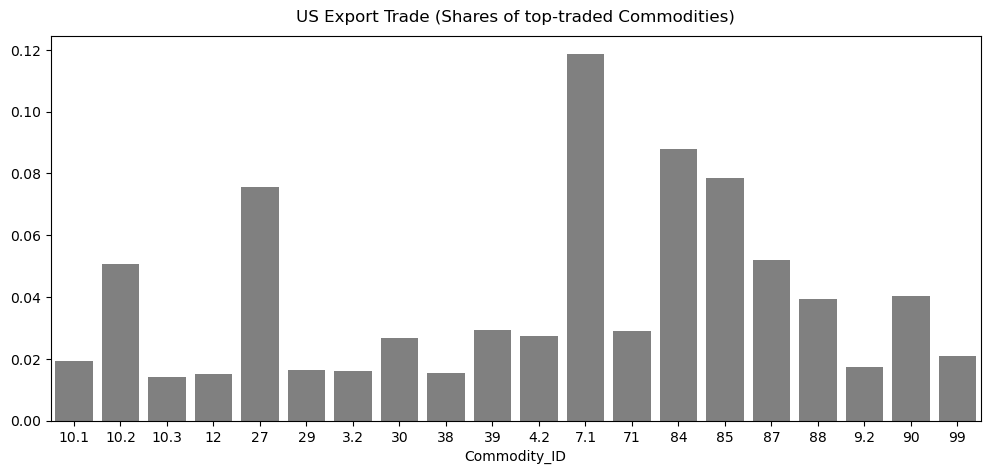

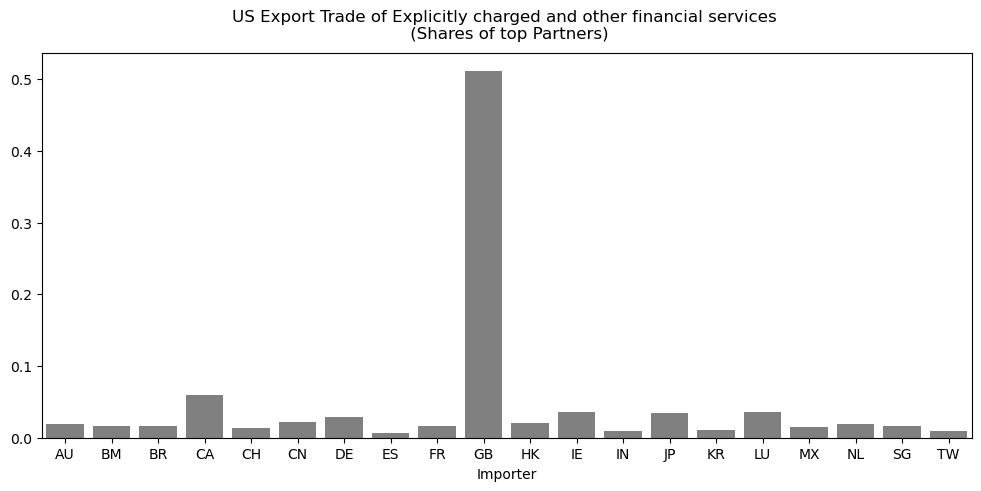

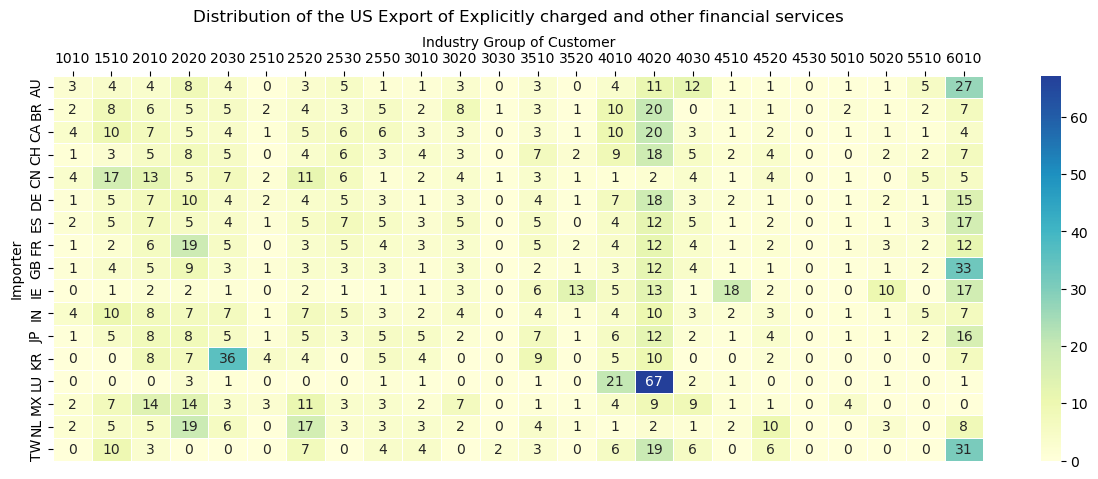

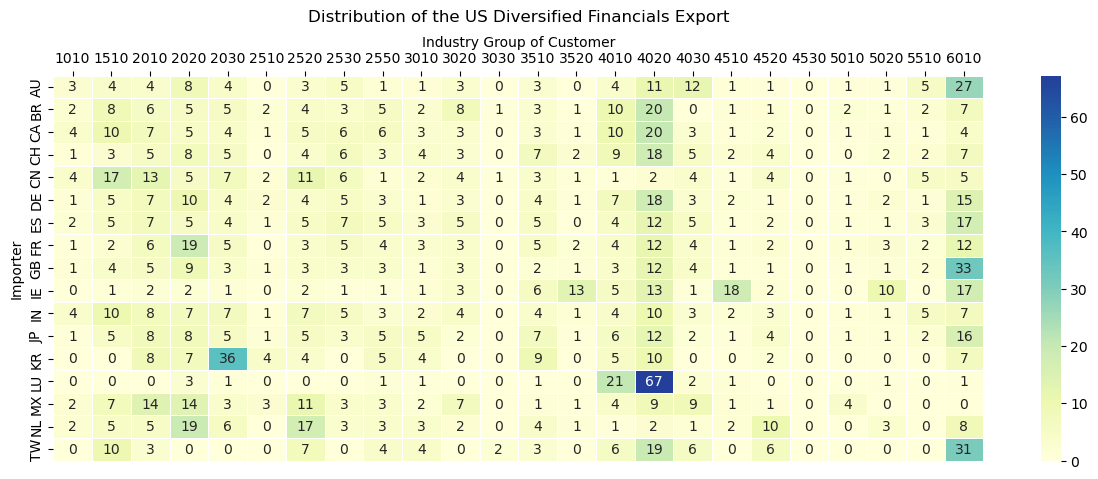

In [43]:
### COUNTRY TO COUNTRY DISTRIBUTION : ENERGY : VISUALIZATION


str_exporter = 'US'
str_commodity = '7.1'
str_group = '4020'

plt.figure(figsize = (12, 5))
ser_export_shares = (ser_comtrade_bil[str_exporter].groupby('Commodity_ID', observed = True).sum() / ser_comtrade_bil[str_exporter].sum()) \
                                                   .fillna(0.0).nlargest(20).sort_index()
ax_barplot = sns.barplot(x = ser_export_shares.index, y = ser_export_shares.values, color = 'gray')
ax_barplot.set_title('US Export Trade (Shares of top-traded Commodities)', pad = 10)
plt.show()

plt.figure(figsize = (12, 5))
ser_importer_shares = (ser_comtrade_bil.loc[str_exporter, :, str_commodity].groupby('Importer', observed = True).sum() / \
                       ser_comtrade_bil[str_exporter, :, str_commodity].sum()).fillna(0.0).nlargest(20).sort_index()
list_importers = ser_importer_shares.index.to_list()
ax_barplot = sns.barplot(x = ser_importer_shares.index, y = ser_importer_shares.values, color = 'gray')
ax_barplot.set_title('US Export Trade of Explicitly charged and other financial services \n ' + 
                     '(Shares of top Partners)', pad = 10)
plt.show()

idx_good_importers = ser_xx_xx_search.index.levels[1].intersection(list_importers)
df_xx_xx_search = ser_xx_xx_search.loc[str_exporter, idx_good_importers, str_commodity].droplevel([0, 2]).unstack('GICS_Group_Code').fillna(0.0)
plt.figure(figsize = (15, 5))
ax_heatmap = sns.heatmap(df_xx_xx_search * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 40, annot = True, fmt = '0.0f')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Distribution of the US Export of Explicitly charged and other financial services', pad = 10)

idx_good_importers = ser_xx_xx_group.index.levels[1].intersection(list_importers)
ser_xx_xx_example = ser_xx_xx_group.loc[str_exporter, idx_good_importers, str_commodity, :, :, str_group].droplevel([3, 4])
ser_xx_xx_result = ser_xx_xx_example.to_frame().join(ser_comtrade_bil).droplevel([0, 3]).groupby(['Importer', 'GICS_Group_Code'], observed = True)\
                                  .apply(lambda df_group: (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum())
ser_xx_xx_result = ser_xx_xx_result.groupby('Importer', observed = True).transform(lambda ser_i: ser_i / ser_i.sum())
df_xx_xx_result = ser_xx_xx_result.unstack('GICS_Group_Code').fillna(0.0)
plt.figure(figsize = (15, 5))
ax_heatmap = sns.heatmap(df_xx_xx_result * 100, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, 
                         square = False, center = 40, annot = True, fmt = '0.0f')
ax_heatmap.set(xlabel = 'Industry Group of Customer')
ax_heatmap.set(ylabel = 'Importer')
ax_heatmap.xaxis.set_ticks_position('top') 
ax_heatmap.xaxis.set_label_position('top')
ax_heatmap.set_title('Distribution of the US Diversified Financials Export', pad = 10)

plt.show()

In [ ]:
### WW TO WW DATA COLLECTION (BASED ON WIOT 2014 SUPPLY / USE MATRICES)

In [139]:
### DATA PREPARATION

### Industry Groups substitution order loading:
ser_gics_substitution = pd.read_excel(str_path_matrix_map, str_sheet_gics_substitution, dtype = 'str', index_col = None)\
                          .set_index('Industry Group').dropna().squeeze()
ser_gics_substitution.index.names = ['Commodity_Group_Code']
ser_gics_substitution.name = 'Substitute'
### World matrices collection:
dict_ww_ww_by_group = {}
### Looding over years of trade:
for iter_date in pd.date_range('2000', '2022', freq = 'BY'):
#for iter_date in ['2000-12-29', '2020-12-31']:
    gc.collect()
    print(iter_date)
    ### Loading distribution of connodities dataset:
    ser_ww_ww_use_ind = pd.read_hdf(str_path_unc_ind_weights_agg_hdf, where = "Date in [iter_date]").droplevel('Date')['WW', 'WW']   
    ### Aggregating to Industry Groups of Customer:
    df_ww_ww_use_ind = ser_ww_ww_use_ind.to_frame().reset_index('GICS_Industry_Code')
    df_ww_ww_use_ind['GICS_Group_Code'] = df_ww_ww_use_ind['GICS_Industry_Code'].str[: 4]
    ser_ww_ww_use_group = df_ww_ww_use_ind.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                        .groupby(['Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
    ### Comtrade dataset loading:
    ser_comtrade_bil = pd.read_hdf(str_path_export_bilateral, where = "Date in [iter_date]").droplevel(['Date', 'Type'])
    ser_comtrade_bil.index.names = ['Exporter', 'Importer', 'Commodity_ID']
    ser_comtrade_ww_ww = (ser_comtrade_bil.groupby(['Commodity_ID']).sum() / 1000).astype(int)
    ser_ww_ww_by_group = ser_ww_ww_use_group.to_frame().join(ser_comtrade_ww_ww).groupby(['Commodity_Group_Code', 'GICS_Group_Code'])\
                                            .apply(lambda df_group: (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum())
    ser_ww_ww_by_group = ser_ww_ww_by_group.groupby('Commodity_Group_Code').transform(lambda ser_i: ser_i / ser_i.sum())    
    ### Adding values for missed Industry Groups:
    df_ww_ww_by_group = ser_ww_ww_by_group.unstack('GICS_Group_Code').fillna(0.0).reindex(ser_gics_substitution.index).fillna(0.0)
    for iter_group in ser_gics_substitution.index:
        if (df_ww_ww_by_group.loc[iter_group].sum() == 0.0):
            df_ww_ww_by_group.loc[iter_group] = df_ww_ww_by_group.loc[ser_gics_substitution[iter_group]]
    ser_ww_ww_by_group = df_ww_ww_by_group.stack('GICS_Group_Code').sort_index()    
    ### Saving of augmented dataset:
    dict_ww_ww_by_group[iter_date] = ser_ww_ww_by_group    
#    display((ser_ww_ww_by_group.unstack('GICS_Group_Code') * 100).round(0))
#    break
### Matrices concatenation:
ser_ww_ww_history = pd.concat(dict_ww_ww_by_group, axis = 0, names = ['Date']).sort_index()#.unstack('GICS_Group_Code')
ser_ww_ww_history.name = 'Share'

2000-12-29 00:00:00
2001-12-31 00:00:00
2002-12-31 00:00:00
2003-12-31 00:00:00
2004-12-31 00:00:00
2005-12-30 00:00:00
2006-12-29 00:00:00
2007-12-31 00:00:00
2008-12-31 00:00:00
2009-12-31 00:00:00
2010-12-31 00:00:00
2011-12-30 00:00:00
2012-12-31 00:00:00
2013-12-31 00:00:00
2014-12-31 00:00:00
2015-12-31 00:00:00
2016-12-30 00:00:00
2017-12-29 00:00:00
2018-12-31 00:00:00
2019-12-31 00:00:00
2020-12-31 00:00:00
2021-12-31 00:00:00


In [140]:
### RESULTS SAVING

ser_ww_ww_history.to_excel('Data_Files/Test_Files/ww_to_ww_shares.xlsx', merge_cells = False)
ser_ww_ww_history.to_csv('Data_Files/Test_Files/ww_to_ww_shares.csv', sep = ',')

In [151]:
### DATA PREPARATION

### Industry Groups substitution order loading:
ser_gics_substitution = pd.read_excel(str_path_matrix_map, str_sheet_gics_substitution, dtype = 'str', index_col = None)\
                          .set_index('Industry Group').dropna().squeeze()
ser_gics_substitution.index.names = ['Commodity_Group_Code']
ser_gics_substitution.name = 'Substitute'
### World matrices collection:
dict_ww_ww_by_group = {}
### Looding over years of trade:
#for iter_date in pd.date_range('2000', '2022', freq = 'BY'):
#for iter_date in ['2000-12-29', '2020-12-31']:
for iter_date in ['2020-12-31']:
    gc.collect()
    print(iter_date)
    ### Loading distribution of connodities dataset:
    ser_ww_ww_use_ind = pd.read_hdf(str_path_unc_ind_weights_full_hdf, where = "Date in [iter_date]").droplevel('Date')['WW', 'WW']   
    ### Aggregating to Industry Groups of Customer:
    df_ww_ww_use_ind = ser_ww_ww_use_ind.to_frame().reset_index('GICS_Industry_Code')
    df_ww_ww_use_ind['GICS_Group_Code'] = df_ww_ww_use_ind['GICS_Industry_Code'].str[: 4]
    ser_ww_ww_use_group = df_ww_ww_use_ind.dropna().set_index('GICS_Group_Code', append = True).sort_index()['Share']\
                                        .groupby(['Commodity_ID', 'Commodity_Group_Code', 'GICS_Group_Code'], observed = True).sum()
    ### Comtrade dataset loading:
    ser_comtrade_bil = pd.read_hdf(str_path_export_bilateral, where = "Date in [iter_date]").droplevel(['Date', 'Type'])
    ser_comtrade_bil.index.names = ['Exporter', 'Importer', 'Commodity_ID']
    ser_comtrade_ww_ww = (ser_comtrade_bil.groupby(['Commodity_ID']).sum() / 1000).astype(int)
    ser_ww_ww_by_group = ser_ww_ww_use_group.to_frame().join(ser_comtrade_ww_ww).groupby(['Commodity_Group_Code', 'GICS_Group_Code'])\
                                            .apply(lambda df_group: (df_group['Share'] * df_group['Export']).sum() / df_group['Export'].sum())
    ser_ww_ww_by_group = ser_ww_ww_by_group.groupby('Commodity_Group_Code').transform(lambda ser_i: ser_i / ser_i.sum())    
    ### Adding values for missed Industry Groups:
    df_ww_ww_by_group = ser_ww_ww_by_group.unstack('GICS_Group_Code').fillna(0.0).reindex(ser_gics_substitution.index).fillna(0.0)
    for iter_group in ser_gics_substitution.index:
        if (df_ww_ww_by_group.loc[iter_group].sum() == 0.0):
            df_ww_ww_by_group.loc[iter_group] = df_ww_ww_by_group.loc[ser_gics_substitution[iter_group]]
    ser_ww_ww_by_group = df_ww_ww_by_group.stack('GICS_Group_Code').sort_index()    
    ### Saving of augmented dataset:
#    dict_ww_ww_by_group[iter_date] = ser_ww_ww_by_group    
##    display((ser_ww_ww_by_group.unstack('GICS_Group_Code') * 100).round(0))
##    break
#### Matrices concatenation:
#ser_ww_ww_history = pd.concat(dict_ww_ww_by_group, axis = 0, names = ['Date']).sort_index()#.unstack('GICS_Group_Code')
#ser_ww_ww_history.name = 'Share'

2020-12-31


In [154]:
### TEMP

(ser_ww_ww_by_group.unstack('GICS_Group_Code') * 100).astype(int)

GICS_Group_Code       1010  1510  2010  2020  2030  2510  2520  2530  2550  \
Commodity_Group_Code                                                         
1010                    26    25     4     1    11     0     3     1     1   
1510                     3    38    15     2     1     4    11     2     1   
2010                     3     6    35     4     5    16     9     2     3   
2020                     3     8     7    13     3     2     5     5     5   
2030                     2    12     8     9    16     2     6     8     2   
2510                     2     8    23     5     1     4    22     4     1   
2520                     2     8    23     5     1     4    22     4     1   
2530                     2    10     7    11    15     1     4     7     6   
2550                     2     8    23     5     1     4    22     4     1   
3010                     0     2     0     1     0     0     2    13     0   
3020                     0     2     0     1     0     0     2    13     0   
3030                     1    18     3     3     0     1     5     2     0   
3510                     0     2     1     1     0     1     1     1     0   
3520                     0     2     1     1     0     1     1     1     0   
4010                     3     9     7     7     6     1     6     5     2   
4020                     3     9     7     7     6     1     6     5     2   
4030                     1     4     3     5     7     0     2     2     1   
4510                     1     4     4    10     4     0     6     5     3   
4520                     1     2    11     5     0     2    36     2     0   
4530                     1     2    11     5     0     2    36     2     0   
5010                     0     2     6     9     5     0     5     6     3   
5020                     0     6     4    14     2     0     5    10     4   
5510                    70    18     1     1     1     0     1     1     0   
6010                     3     9     7     7     6     1     6     5     2   

GICS_Group_Code       3010  ...  4010  4020  4030  4510  4520  4530  5010  \
Commodity_Group_Code        ...                                             
1010                     0  ...     0     0     0     0     0     0     0   
1510                     0  ...     0     0     0     0     3     0     0   
2010                     0  ...     0     0     0     0     2     0     0   
2020                     3  ...     1     3     1     2     3     0     1   
2030                     2  ...     0     2     0     0     2     0     0   
2510                     0  ...     0     0     0     0     9     0     1   
2520                     0  ...     0     0     0     0     9     0     1   
2530                     2  ...     2     2     4     0     2     0     1   
2550                     0  ...     0     0     0     0     9     0     1   
3010                     0  ...     0     0     0     0     0     0     0   
3020                     0  ...     0     0     0     0     0     0     0   
3030                     0  ...     0     0     0     0     1     0     0   
3510                     0  ...     0     0     0     0     0     0     0   
3520                     0  ...     0     0     0     0     0     0     0   
4010                     2  ...     4    11     3     1     2     0     0   
4020                     2  ...     4    11     3     1     2     0     0   
4030                     1  ...     5    18    31     0     1     0     0   
4510                     1  ...     3     8     1    12     2     0     3   
4520                     0  ...     0     0     0     1    20     0     3   
4530                     0  ...     0     0     0     1    20     0     3   
5010                     2  ...     1     5     2     7     2     0    18   
5020                     3  ...     2     4     1     4     2     0     2   
5510                     0  ...     0     0     0     0     0     0     0   
6010                     2  ...     4    11   

In [162]:
### TEMP

(pd.read_csv('Data_Files/Test_Files/ww_to_ww_shares.csv', sep = ',', index_col = [0, 1, 2]).squeeze()['2020-12-31'].unstack('GICS_Group_Code') * 100).astype(int)

GICS_Group_Code       1010  1510  2010  2020  2030  2510  2520  2530  2550  \
Commodity_Group_Code                                                         
1010                    23    22     4     1    11     0     3     1     1   
1510                     5    36    15     2     0     3    12     2     1   
2010                     3     5    36     3     5    16    12     1     3   
2020                     3     8     7    13     3     2     5     5     5   
2030                     2    12     8    10    16     2     6     9     1   
2510                     2     7    23     5     2     4    21     4     1   
2520                     2     7    23     5     2     4    21     4     1   
2530                     2    10     7    11    16     1     4     7     6   
2550                     2     7    23     5     2     4    21     4     1   
3010                     0     3     0     0     0     0     2    13     0   
3020                     0     3     0     0     0     0     2    13     0   
3030                     0    19     3     3     0     1     4     2     0   
3510                     0     2     1     1     0     1     1     1     0   
3520                     0     2     1     1     0     1     1     1     0   
4010                     3     9     7     7     6     1     6     5     2   
4020                     3     9     7     7     6     1     6     5     2   
4030                     0     2     1     3     4     0     1     1     1   
4510                     1     4     4    10     4     0     8     4     3   
4520                     1     2    11     5     0     2    36     2     0   
4530                     1     2    11     5     0     2    36     2     0   
5010                     0     2     6     9     5     0     5     6     3   
5020                     0     6     4    15     2     0     5    10     4   
5510                    39    17     4     5     5     2     4     6     0   
6010                     3     9     7     7     6     1     6     5     2   

GICS_Group_Code       3010  ...  4010  4020  4030  4510  4520  4530  5010  \
Commodity_Group_Code        ...                                             
1010                     0  ...     0     0     0     0     0     0     0   
1510                     0  ...     0     0     0     0     2     0     0   
2010                     0  ...     0     0     0     0     1     0     0   
2020                     3  ...     1     3     1     2     3     0     1   
2030                     3  ...     1     2     0     0     3     0     0   
2510                     0  ...     0     0     0     0     9     0     1   
2520                     0  ...     0     0     0     0     9     0     1   
2530                     2  ...     2     2     4     0     2     0     1   
2550                     0  ...     0     0     0     0     9     0     1   
3010                     0  ...     0     0     0     0     0     0     0   
3020                     0  ...     0     0     0     0     0     0     0   
3030                     0  ...     0     0     0     0     1     0     0   
3510                     0  ...     0     0     0     0     0     0     0   
3520                     0  ...     0     0     0     0     0     0     0   
4010                     2  ...     4    11     3     1     2     0     0   
4020                     2  ...     4    11     3     1     2     0     0   
4030                     0  ...     4    15    51     0     0     0     0   
4510                     1  ...     3     8     1    12     4     0     3   
4520                     0  ...     0     0     0     1    20     0     3   
4530                     0  ...     0     0     0     1    20     0     3   
5010                     2  ...     1     5     2     7     2     0    18   
5020                     3  ...     2     4     1     4     2     0     2   
5510                     0  ...     0     0     0     0     0     0     0   
6010                     2  ...     4    11   

In [ ]:
### MAPPINGS PREPARATION

In [42]:
### PRIMARY CELLS PREPARATION

### Basic total shares loading:
ser_total_shares = pd.read_excel(str_path_primary, str_sheet_cells, header = 0).drop('Group', axis = 1).drop([0, 55, 56], axis = 0).set_index('WIOT').stack()
ser_total_shares.index.names = ['WIOT Exporter Code', 'WIOT Importer Code']
### Extracting primary cells:
ser_primary_shares = ser_total_shares[ser_total_shares > 0.05]
ser_primary_shares.name = 'Share'
### R Map:
df_r_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_r, dtype = str)[['WIOT Exporter Code', 'HS Goods Code', 'EBOPS Service Code', 'Commodity Description']]
df_r_map['WIOT Exporter Code'] = df_r_map['WIOT Exporter Code'].ffill()
df_r_map['Commodity_ID'] = df_r_map['HS Goods Code'].combine_first(df_r_map['EBOPS Service Code'])
df_r_map = df_r_map.set_index('WIOT Exporter Code')[['Commodity_ID', 'Commodity Description']].dropna()
### C Map:
df_c_map = pd.read_excel(str_path_matrix_map, str_sheet_nace_c, dtype = str)[['WIOT Importer Code', 'GICS Sub-Industry Code', 'GICS Sub-Industry Name']].dropna()
df_c_map['WIOT Importer Code'] = df_c_map['WIOT Importer Code'].ffill()
df_c_map = df_c_map.dropna(subset = ['GICS Sub-Industry Code']).set_index('WIOT Importer Code')
df_c_map['GICS Sub-Industry Code'] = df_c_map['GICS Sub-Industry Code'].astype(str)
### CMappers consolidation:
df_primary_shares = ser_primary_shares.reset_index('WIOT Importer Code').merge(df_r_map, left_on = 'WIOT Exporter Code', right_on = 'WIOT Exporter Code')\
                                      .set_index('WIOT Importer Code', append = True)
df_primary_shares = df_primary_shares.reset_index('WIOT Exporter Code').merge(df_c_map, left_on = 'WIOT Importer Code', right_on = 'WIOT Importer Code')\
                                      .set_index('WIOT Exporter Code', append = True)
df_primary_shares = df_primary_shares.swaplevel().sort_index()

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [43]:
### UN COMTRADE TO GICS WIOT BASED MATRIX LOADING

### Source table loading:
df_unc_to_gics = pd.read_excel(engine = 'openpyxl', io = str_path_matrix_map, sheet_name = str_sheet_matrix, dtype = str, header = list(range(6)), 
                               index_col = list(range(4)))
df_unc_to_gics.index.names = ['WIOT Exporter Code', 'WIOT_Description', 'Commodity_ID', 'Commodity_Description']
df_unc_to_gics.columns.names = ['WIOT Importer Code', 'WIOT_Description', 'GICS_Sub_Code', 'GICS_Industry_Code', 'GICS_Group_Code', 'GICS_Sub_Name']
### Index levels checker:
df_unc_to_gics.index = df_unc_to_gics.index.set_levels(df_unc_to_gics.index.levels[2].astype('str'), level = 'Commodity_ID')
#### Matrix filtering:
df_unc_to_gics = df_unc_to_gics.drop(index = '---', level = 'Commodity_ID').drop(columns = '---', level = 'GICS_Group_Code')
df_unc_to_gics = df_unc_to_gics.droplevel(['WIOT_Description', 'GICS_Industry_Code', 'GICS_Group_Code', 'GICS_Sub_Name'], axis = 1)
df_unc_to_gics = df_unc_to_gics.droplevel(['WIOT_Description', 'Commodity_Description'])
#df_unc_to_gics['GICS_Sub_Code'] = df_unc_to_gics['GICS_Sub_Code'].astype(str)
### Matrix convertation:
df_unc_to_gics = df_unc_to_gics.replace({'x': False, 'y': True, 'z': True})
gc.collect()
ser_unc_to_gics = df_unc_to_gics.stack(df_unc_to_gics.columns.names).astype(bool)
ser_unc_to_gics.index = ser_unc_to_gics.index.set_levels(ser_unc_to_gics.index.levels[3].astype('str'), level = 'GICS_Sub_Code')
ser_unc_to_gics.name = 'Connection_Flag'

In [44]:
### ADDING CONNECTION FLAGS

df_primary_shares.index.names = ['WIOT Exporter Code', 'WIOT Importer Code']
df_primary_shares = df_primary_shares.set_index(['Commodity_ID', 'GICS Sub-Industry Code'], append = True).reorder_levels([0, 2, 1, 3]).sort_index()
df_primary_shares.index.names = ser_unc_to_gics.index.names
df_primary_shares['Connection_Flag'] = ser_unc_to_gics.reindex(df_primary_shares.index)
df_primary_shares = df_primary_shares.set_index(['Commodity Description', 'GICS Sub-Industry Name'], append = True).reorder_levels([0, 1, 4, 2, 3, 5]).sort_index()

In [49]:
### HS19992 STRUCTURE PREPARATION:

### Data loading:
df_hs_full = pd.DataFrame(pd.read_json(str_hs_url, orient = 'index').squeeze()['results']).set_index('id')
### Parents & Offspring:
ser_ag2 = df_hs_full[df_hs_full['parent'] == 'TOTAL'].drop('parent', axis = 1).squeeze()
ser_ag2.name = 'AG2_Description'
df_ag4 = df_hs_full[df_hs_full['parent'].isin(ser_ag2.index)]
df_ag4.columns = ['AG4_Description', 'Parent']
df_ag4 = df_ag4.merge(ser_ag2, left_on = 'Parent', right_on = 'id').set_index('Parent')[['AG2_Description', 'AG4_Description']]
df_ag4.to_excel('Data_Files/Test_Files/hs_1992_ag4.xlsx')